#**Plant Leaf Disease Detection Notebook**

### **(A Project of Horair Ahmad,Mabtoor-Ul-Shafiq and Muhammad Waqas Under the Supervision of Miss Raheela at University of Agriculture Faisalabad)**

Notebook is designed to Classify the category and disease of plants using  Transfer Learning.  **We Used 6 Different Models to get Maximum Accuracy and Minimum Loss.** The 6 Different models are: 

* EfficientNetB0

* MobileNetV2

* EfficientNetV2B3

* Resnet50

* DenseNet121

* InceptionV3



**In our case, EfficientNetB0 model gives us best accuracy. We get 97% accuracy in Feature Extraction and 99% accuracy in Fine-Tuning.**

The Dataset We Using :  https://www.kaggle.com/datasets/arjuntejaswi/plant-village

For More Information: Visit the Github Repositories

https://github.com/horair (Horair Ahmad)

https://github.com/Mabtoor-Mabx (Mabtoor-Ul-Shafiq)

https://github.com/waqasmuhammad (Muhammad Waqas)


# **1-Checking GPU**

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0ac4c4f0-ac65-5ed9-ab3b-2bbb2b22b696)


# **2- Import Libraries**

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **3- Creating Helper Function**

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-14 13:02:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-14 13:02:19 (63.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **4- Import Series of Functions from helping function**

In [5]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **5- Install and import split folders**

In [6]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import splitfolders

# **6- Mount Google Drive**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **7- Import Dataset from google Drive**

In [9]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Deep_Learning_Datasets_For_Practice_Purposes/Plant_leaf_diseases_dataset_with_augmentation.zip")
zip_ref.extractall()
zip_ref.close()

# **8-Split Dataset**

In [10]:
splitfolders.ratio("/content/Plant_leave_diseases_dataset_with_augmentation", output="output_1",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 61486 files [00:09, 6733.55 files/s]


# **9- Train , Test and Validation Directories**

In [11]:
train_dir_1 = "/content/output_1/train"
val_dir_1 = "/content/output_1/val"
test_dir_1 = "/content/output_1/test"

In [12]:
# How many images/classes are there?
walk_through_dir("output_1")

There are 3 directories and 0 images in 'output_1'.
There are 39 directories and 0 images in 'output_1/test'.
There are 0 directories and 160 images in 'output_1/test/Tomato___healthy'.
There are 0 directories and 552 images in 'output_1/test/Orange___Haunglongbing_(Citrus_greening)'.
There are 0 directories and 117 images in 'output_1/test/Corn___healthy'.
There are 0 directories and 100 images in 'output_1/test/Grape___healthy'.
There are 0 directories and 100 images in 'output_1/test/Tomato___Early_blight'.
There are 0 directories and 100 images in 'output_1/test/Potato___Early_blight'.
There are 0 directories and 100 images in 'output_1/test/Apple___Apple_scab'.
There are 0 directories and 112 images in 'output_1/test/Strawberry___Leaf_scorch'.
There are 0 directories and 139 images in 'output_1/test/Grape___Esca_(Black_Measles)'.
There are 0 directories and 509 images in 'output_1/test/Soybean___healthy'.
There are 0 directories and 192 images in 'output_1/test/Tomato___Late_bligh

# **10- Setup data inputs**

In [13]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                label_mode="categorical",
                                                                 batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=True)
val_data =  tf.keras.preprocessing.image_dataset_from_directory(val_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 49179 files belonging to 39 classes.
Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


# **11- Create Checkpoint Callback**

In [14]:
# Create a checkpoint callback
checkpoint_path = "/content/plants"
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=2, verbose=1)

mc = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_path, min_delta=0.01, patience=3, verbose=1, save_best_only=True)

cb = [es, mc]


# **12- Data Augmentation**

In [15]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")



# **Model 1 (EfficientNetB0)**

## **13-Setup Base Model and Freeze the layers Using EfficientNetB0**

In [ ]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 39)                49959     
                                                                 
Total params: 4,099,530
Trainable params: 49,959
Non-trainabl

## **14-Applying Feature Extraction**

In [ ]:
from tensorflow.keras import metrics

In [ ]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history = model.fit(train_data,
                    epochs=10, # fit to 5 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/10
1537/1537 [==============================] - 329s 202ms/step - loss: 0.6199 - tp: 34918.0000 - fp: 1247.0000 - tn: 1867555.0000 - fn: 14261.0000 - accuracy: 0.8552 - precision: 0.9655 - recall: 0.7100 - auc: 0.9954 - val_loss: 0.2793 - val_tp: 5395.0000 - val_fp: 223.0000 - val_tn: 233059.0000 - val_fn: 744.0000 - val_accuracy: 0.9208 - val_precision: 0.9603 - val_recall: 0.8788 - val_auc: 0.9990
Epoch 2/10
1537/1537 [==============================] - 211s 137ms/step - loss: 0.2376 - tp: 44227.0000 - fp: 1536.0000 - tn: 1867266.0000 - fn: 4952.0000 - accuracy: 0.9380 - precision: 0.9664 - recall: 0.8993 - auc: 0.9991 - val_loss: 0.2045 - val_tp: 5605.0000 - val_fp: 229.0000 - val_tn: 233053.0000 - val_fn: 534.0000 - val_accuracy: 0.9378 - val_precision: 0.9607 - val_recall: 0.9130 - val_auc: 0.9989
Epoch 3/10
1537/1537 [==============================] - 182s 118ms/step - loss: 0.1773 - tp: 45619.0000 - fp: 1386.0000 - tn: 1867416.0000 - fn: 3560.0000 - accuracy: 0.9516 - pre

## **15-Evaluate Whole Dataset**

In [ ]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

193/193 [==============================] - 15s 75ms/step - loss: 0.1173 - tp: 5895.0000 - fp: 183.0000 - tn: 234201.0000 - fn: 273.0000 - accuracy: 0.9624 - precision: 0.9699 - recall: 0.9557 - auc: 0.9993


[0.11733626574277878,
 5895.0,
 183.0,
 234201.0,
 273.0,
 0.9623864889144897,
 0.9698914289474487,
 0.9557393193244934,
 0.999319314956665]

## **16-Graph of Feature Extraction**

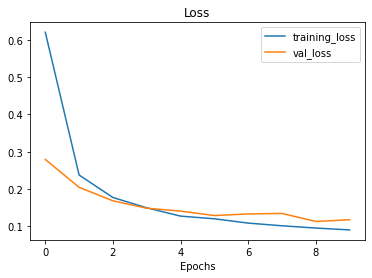

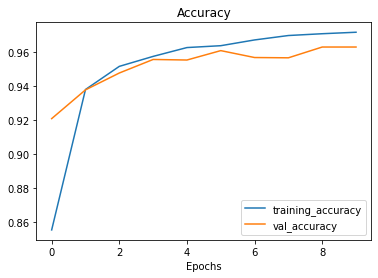

In [ ]:
plot_loss_curves(history)

## **17-Fine-Tuning Model Using EfficientNetB0**

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
output_layer True


In [ ]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 151s 93ms/step - loss: 0.0867 - tp: 53460.0000 - fp: 1299.0000 - tn: 2101887.0000 - fn: 1887.0000 - accuracy: 0.9705 - precision: 0.9763 - recall: 0.9659 - auc: 0.9994 - val_loss: 0.1029 - val_tp: 5919.0000 - val_fp: 176.0000 - val_tn: 233106.0000 - val_fn: 220.0000 - val_accuracy: 0.9674 - val_precision: 0.9711 - val_recall: 0.9642 - val_auc: 0.9989
Epoch 11/20
1537/1537 [==============================] - 139s 90ms/step - loss: 0.0674 - tp: 47930.0000 - fp: 907.0000 - tn: 1867895.0000 - fn: 1249.0000 - accuracy: 0.9778 - precision: 0.9814 - recall: 0.9746 - auc: 0.9995 - val_loss: 0.0733 - val_tp: 5984.0000 - val_fp: 125.0000 - val_tn: 233157.0000 - val_fn: 155.0000 - val_accuracy: 0.9769 - val_precision: 0.9795 - val_recall: 0.9748 - val_auc: 0.9994
Epoch 12/20
1537/1537 [==============================] - 139s 90ms/step - loss: 0.0597 - tp: 48084.0000 - fp: 839.0000 - tn: 1867963.0000 - fn: 1095.0000 - accuracy: 0.9802 - precis

## **18- Evaluate Fine-Tune Model**

In [ ]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

193/193 [==============================] - 14s 73ms/step - loss: 0.0603 - tp: 6035.0000 - fp: 120.0000 - tn: 234264.0000 - fn: 133.0000 - accuracy: 0.9799 - precision: 0.9805 - recall: 0.9784 - auc: 0.9993


[0.06033874303102493,
 6035.0,
 120.0,
 234264.0,
 133.0,
 0.9798962473869324,
 0.9805036783218384,
 0.978437066078186,
 0.9992956519126892]

## **19-Compare The Histories**

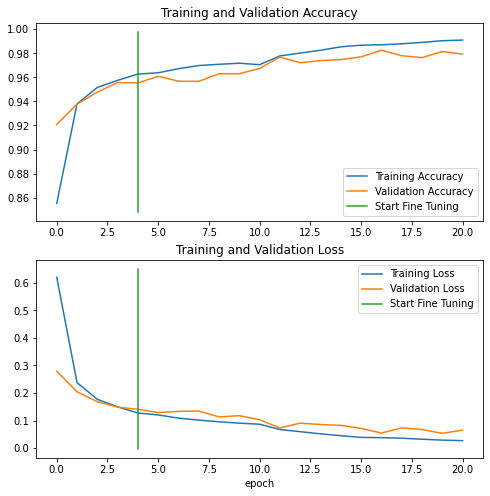

In [ ]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## **20-Saving and Loading The Model**

In [ ]:
# # Save our fine-tuning model
# model.save("drive/MyDrive/Deep_Learning_Model/Plant_leaf_disease_Detection_Models")

In [ ]:
# # Load and evaluate saved model
# loaded_model =tf.keras.models.load_model("drive/MyDrive/Deep_Learning_Model/Plant_leaf_disease_Detection_Models")

In [ ]:
# # Evaluate loaded model and compare performance to pre-saved model
# loaded_model_results = loaded_model.evaluate(test_data)
# loaded_model_results

In [ ]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[0.06033874303102493,
 6035.0,
 120.0,
 234264.0,
 133.0,
 0.9798962473869324,
 0.9805036783218384,
 0.978437066078186,
 0.9992956519126892]

## **21-Making Prediction with Trained Model**

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 14s 65ms/step


In [ ]:
len(test_data)

193

In [ ]:
# How many predictions are there?
len(preds_probs)

6168

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(6168, 39)

In [ ]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[9.99964595e-01, 4.10932074e-07, 1.57549191e-08, 4.46728791e-07,
        5.54373984e-13, 2.02908945e-15, 5.01858644e-08, 2.40296010e-13,
        6.83076555e-12, 4.25850327e-12, 5.09076514e-09, 1.70004442e-14,
        2.82287388e-10, 4.14504715e-11, 1.65724356e-09, 4.69510336e-13,
        2.62623528e-13, 7.54041274e-09, 3.35788323e-14, 1.65067013e-06,
        3.81900024e-13, 3.14987847e-05, 1.23347547e-06, 1.74058728e-12,
        5.02560233e-14, 8.27844412e-13, 5.74026426e-09, 2.96042219e-11,
        3.18441291e-13, 1.64970251e-13, 2.08893302e-11, 7.60022516e-08,
        2.19990974e-12, 3.07231374e-09, 1.27002006e-13, 1.19539024e-07,
        1.21724642e-19, 2.59537221e-16, 1.48328891e-10],
       [9.82972443e-01, 3.73883680e-08, 1.68092338e-05, 1.69907361e-02,
        7.87826401e-11, 8.62871146e-12, 2.37723119e-10, 8.75065211e-07,
        2.69945982e-10, 6.52988687e-12, 2.65565916e-07, 3.02606247e-13,
        1.02657477e-05, 6.07147943e-10, 4.29350955e-09, 3.84247414e-06,
       

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([9.9996459e-01, 4.1093207e-07, 1.5754919e-08, 4.4672879e-07,
        5.5437398e-13, 2.0290894e-15, 5.0185864e-08, 2.4029601e-13,
        6.8307656e-12, 4.2585033e-12, 5.0907651e-09, 1.7000444e-14,
        2.8228739e-10, 4.1450472e-11, 1.6572436e-09, 4.6951034e-13,
        2.6262353e-13, 7.5404127e-09, 3.3578832e-14, 1.6506701e-06,
        3.8190002e-13, 3.1498785e-05, 1.2334755e-06, 1.7405873e-12,
        5.0256023e-14, 8.2784441e-13, 5.7402643e-09, 2.9604222e-11,
        3.1844129e-13, 1.6497025e-13, 2.0889330e-11, 7.6002252e-08,
        2.1999097e-12, 3.0723137e-09, 1.2700201e-13, 1.1953902e-07,
        1.2172464e-19, 2.5953722e-16, 1.4832889e-10], dtype=float32),
 39,
 1.0000001205562337)

In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [9.9996459e-01 4.1093207e-07 1.5754919e-08 4.4672879e-07 5.5437398e-13
 2.0290894e-15 5.0185864e-08 2.4029601e-13 6.8307656e-12 4.2585033e-12
 5.0907651e-09 1.7000444e-14 2.8228739e-10 4.1450472e-11 1.6572436e-09
 4.6951034e-13 2.6262353e-13 7.5404127e-09 3.3578832e-14 1.6506701e-06
 3.8190002e-13 3.1498785e-05 1.2334755e-06 1.7405873e-12 5.0256023e-14
 8.2784441e-13 5.7402643e-09 2.9604222e-11 3.1844129e-13 1.6497025e-13
 2.0889330e-11 7.6002252e-08 2.1999097e-12 3.0723137e-09 1.2700201e-13
 1.1953902e-07 1.2172464e-19 2.5953722e-16 1.4832889e-10]
The class with highest predicted probability by the model for sample 0: 0


In [ ]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([ 0,  0,  0, 17,  0,  0,  0,  0,  0,  0])

In [ ]:
# How many pred classes we have?
len(pred_classes)

6168

In [ ]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

6168

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None))>

In [ ]:
len(test_data)

193

## **22-Lets Create Confusion Matrix**

In [ ]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[0.06033874303102493,
 6035.0,
 120.0,
 234264.0,
 133.0,
 0.9798962473869324,
 0.9805036783218384,
 0.978437066078186,
 0.9992956519126892]

In [ ]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

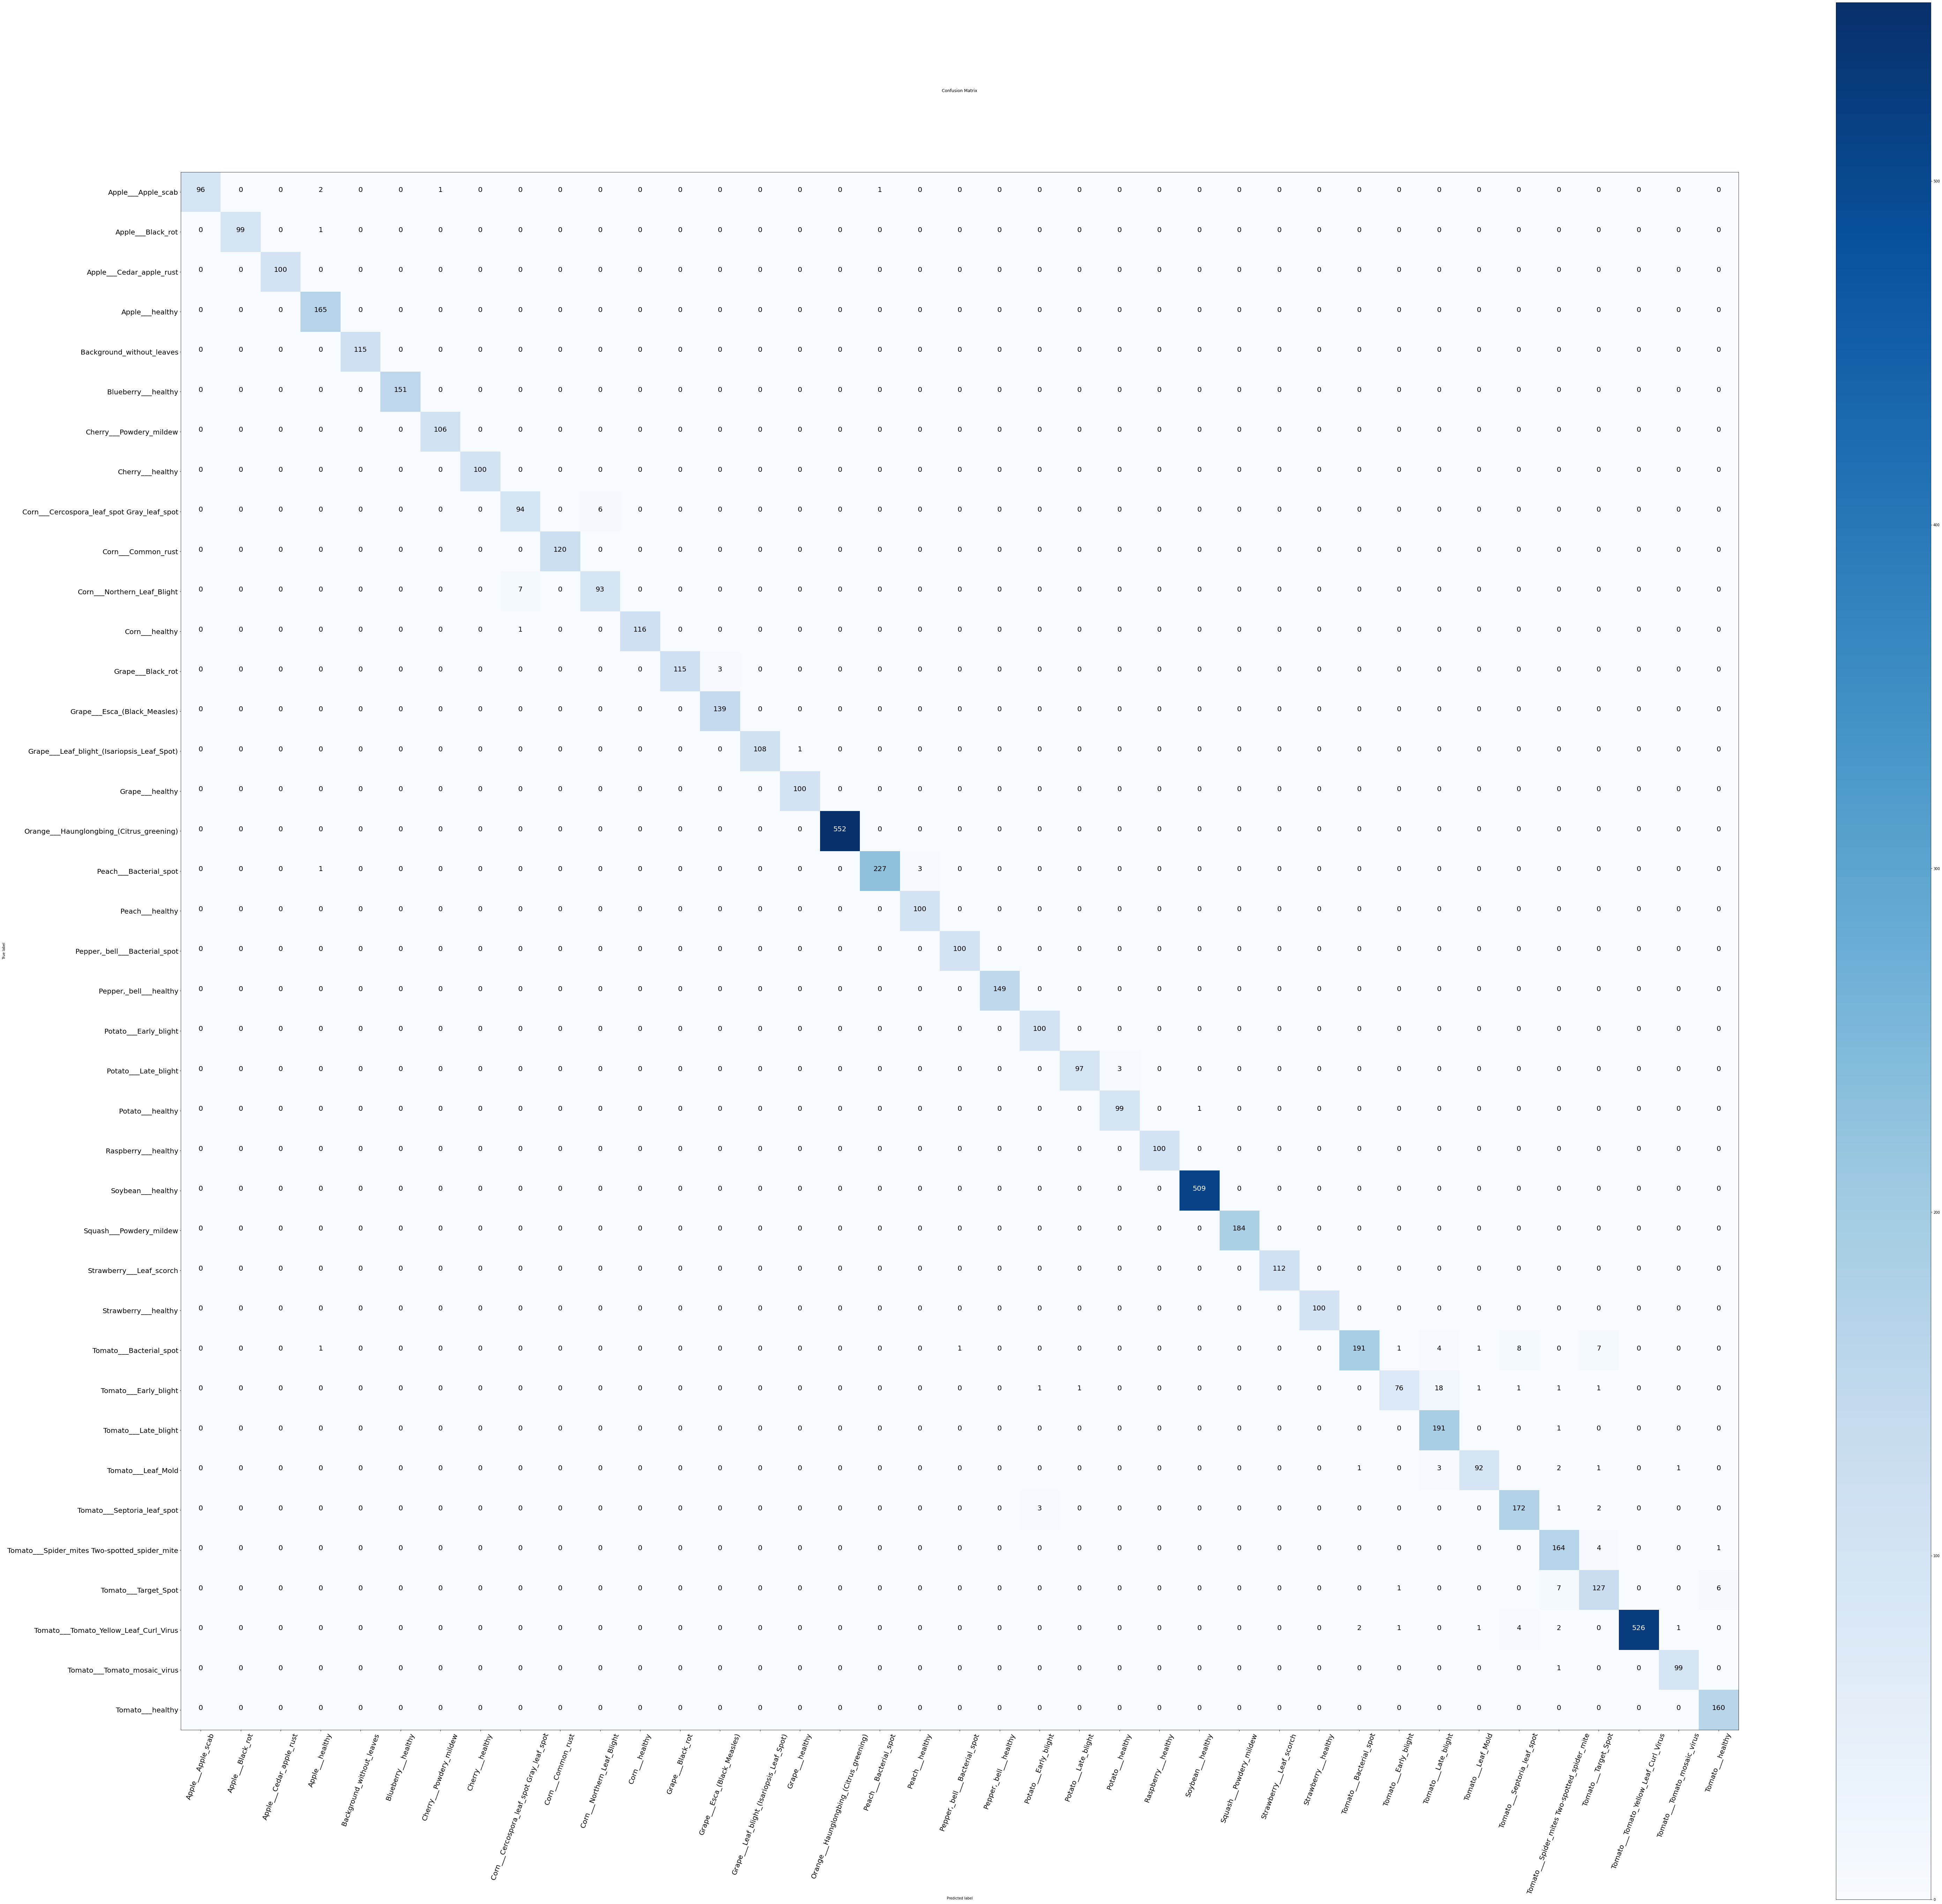

In [ ]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## **23-To Keep Evaluation On Track, Let's Create Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       1.00      0.99      0.99       100
           2       1.00      1.00      1.00       100
           3       0.97      1.00      0.99       165
           4       1.00      1.00      1.00       115
           5       1.00      1.00      1.00       151
           6       0.99      1.00      1.00       106
           7       1.00      1.00      1.00       100
           8       0.92      0.94      0.93       100
           9       1.00      1.00      1.00       120
          10       0.94      0.93      0.93       100
          11       1.00      0.99      1.00       117
          12       1.00      0.97      0.99       118
          13       0.98      1.00      0.99       139
          14       1.00      0.99      1.00       109
          15       0.99      1.00      1.00       100
          16       1.00      1.00      1.00       552
          17       1.00    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9795918367346939,
  'precision': 1.0,
  'recall': 0.96,
  'support': 100},
 '1': {'f1-score': 0.9949748743718593,
  'precision': 1.0,
  'recall': 0.99,
  'support': 100},
 '10': {'f1-score': 0.9346733668341709,
  'precision': 0.9393939393939394,
  'recall': 0.93,
  'support': 100},
 '11': {'f1-score': 0.9957081545064378,
  'precision': 1.0,
  'recall': 0.9914529914529915,
  'support': 117},
 '12': {'f1-score': 0.9871244635193133,
  'precision': 1.0,
  'recall': 0.9745762711864406,
  'support': 118},
 '13': {'f1-score': 0.9893238434163701,
  'precision': 0.9788732394366197,
  'recall': 1.0,
  'support': 139},
 '14': {'f1-score': 0.9953917050691244,
  'precision': 1.0,
  'recall': 0.9908256880733946,
  'support': 109},
 '15': {'f1-score': 0.9950248756218906,
  'precision': 0.9900990099009901,
  'recall': 1.0,
  'support': 100},
 '16': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 552},
 '17': {'f1-score': 0.9891067538126361,
  'precision': 0.995614035

In [ ]:
class_names[37]

'Tomato___Tomato_mosaic_virus'

In [ ]:
classification_report_dict["37"]["f1-score"]

0.9850746268656716

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Apple___Apple_scab': 0.9795918367346939,
 'Apple___Black_rot': 0.9949748743718593,
 'Apple___Cedar_apple_rust': 1.0,
 'Apple___healthy': 0.9850746268656716,
 'Background_without_leaves': 1.0,
 'Blueberry___healthy': 1.0,
 'Cherry___Powdery_mildew': 0.9953051643192489,
 'Cherry___healthy': 1.0,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 0.9306930693069307,
 'Corn___Common_rust': 1.0,
 'Corn___Northern_Leaf_Blight': 0.9346733668341709,
 'Corn___healthy': 0.9957081545064378,
 'Grape___Black_rot': 0.9871244635193133,
 'Grape___Esca_(Black_Measles)': 0.9893238434163701,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 0.9953917050691244,
 'Grape___healthy': 0.9950248756218906,
 'Orange___Haunglongbing_(Citrus_greening)': 1.0,
 'Peach___Bacterial_spot': 0.9891067538126361,
 'Peach___healthy': 0.9852216748768473,
 'Pepper,_bell___Bacterial_spot': 0.9950248756218906,
 'Pepper,_bell___healthy': 1.0,
 'Potato___Early_blight': 0.9803921568627451,
 'Potato___Late_blight': 0.9797979797979798,
 

In [ ]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                        

class_names  f1-score
27                       Strawberry___Leaf_scorch  1.000000
28                           Strawberry___healthy  1.000000
2                        Apple___Cedar_apple_rust  1.000000
26                        Squash___Powdery_mildew  1.000000
4                       Background_without_leaves  1.000000
5                             Blueberry___healthy  1.000000
7                                Cherry___healthy  1.000000
24                            Raspberry___healthy  1.000000
9                              Corn___Common_rust  1.000000
20                         Pepper,_bell___healthy  1.000000
16       Orange___Haunglongbing_(Citrus_greening)  1.000000
25                              Soybean___healthy  0.999019
11                                 Corn___healthy  0.995708
14     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  0.995392
6                         Cherry___Powdery_mildew  0.995305
15                                Grape___healthy  0.995025
19                  Pepper,_bell___Bacterial_spot  0.995025
1                               Apple___Black_rot  0.994975
36         Tomato___Tomato_Yellow_Leaf_Curl_Virus  0.989652
13                   Grape___Esca_(Black_Measles)  0.989324
17                         Peach___Bacterial_spot  0.989107
12                              Grape___Black_rot  0.987124
18                                Peach___healthy  0.985222
37                   Tomato___Tomato_mosaic_virus  0.985075
3                                 Apple___healthy  0.985075
21                          Potato___Early_blight  0.980392
23                               Potato___healthy  0.980198
22                           Potato___Late_blight  0.979798
0                              Apple___Apple_scab  0.979592
38                               Tomato___healthy  0.978593
33                    Tomato___Septoria_leaf_spot  0.947658
32                             Tomato___Leaf_Mold  0.943590
34  Tomato___Spider_mites Two-spotted_spider_mite  0.942529
29                        Tomato___Bacterial_spot  0.936275
31                           Tomato___Late_blight  0.936275
10                    Corn___Northern_Leaf_Blight  0.934673
8      Corn___Cercospora_leaf_spot Gray_leaf_spot  0.930693
35                           Tomato___Target_Spot  0.897527
30                          Tomato___Early_blight  0.849162

In [ ]:
f1_scores[:10]

class_names  f1-score
27   Strawberry___Leaf_scorch       1.0
28       Strawberry___healthy       1.0
2    Apple___Cedar_apple_rust       1.0
26    Squash___Powdery_mildew       1.0
4   Background_without_leaves       1.0
5         Blueberry___healthy       1.0
7            Cherry___healthy       1.0
24        Raspberry___healthy       1.0
9          Corn___Common_rust       1.0
20     Pepper,_bell___healthy       1.0

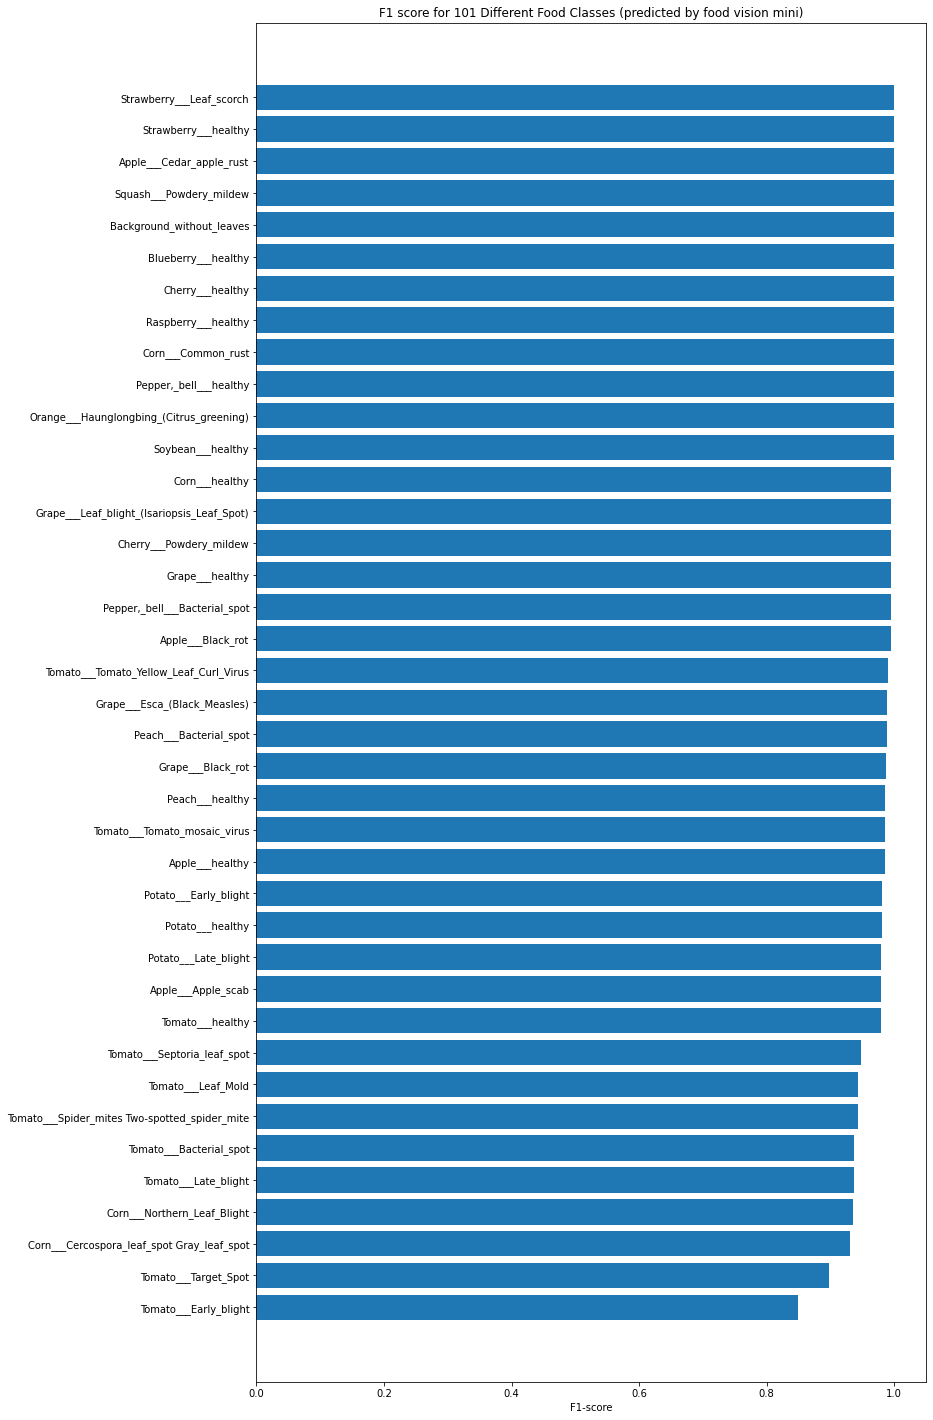

In [ ]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6i71ib14/assets


# **Model 2 (MobileNetV2)**

## **24- Data Augmentation**

In [ ]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation_2 = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")


## **25-Compile and Evaluate The Model**

In [ ]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation_2(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_mobileNet=tf.keras.Model(inputs, outputs)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model_mobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 39)                49959     
                                                           

In [ ]:
# Compile
model_mobileNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_mobileNet_fex = model_mobileNet.fit(train_data,
                                            epochs=10, # fit to 5 epochs to keep experiment quick
                                            validation_data=val_data,
                                            validation_steps=len(val_data))

Epoch 1/10
1537/1537 [==============================] - 97s 60ms/step - loss: 0.4642 - tp: 45253.0000 - fp: 2193.0000 - tn: 2100993.0000 - fn: 10094.0000 - accuracy: 0.8861 - precision: 0.9538 - recall: 0.8176 - auc: 0.9967 - val_loss: 0.2606 - val_tp: 5469.0000 - val_fp: 297.0000 - val_tn: 232985.0000 - val_fn: 670.0000 - val_accuracy: 0.9192 - val_precision: 0.9485 - val_recall: 0.8909 - val_auc: 0.9988
Epoch 2/10
1537/1537 [==============================] - 93s 60ms/step - loss: 0.2042 - tp: 45078.0000 - fp: 2011.0000 - tn: 1866791.0000 - fn: 4101.0000 - accuracy: 0.9360 - precision: 0.9573 - recall: 0.9166 - auc: 0.9988 - val_loss: 0.2053 - val_tp: 5635.0000 - val_fp: 280.0000 - val_tn: 233002.0000 - val_fn: 504.0000 - val_accuracy: 0.9332 - val_precision: 0.9527 - val_recall: 0.9179 - val_auc: 0.9985
Epoch 3/10
1537/1537 [==============================] - 92s 60ms/step - loss: 0.1703 - tp: 45840.0000 - fp: 1828.0000 - tn: 1866974.0000 - fn: 3339.0000 - accuracy: 0.9466 - precision

In [ ]:
result_mobileNet_fex = model_mobileNet.evaluate(test_data)
result_mobileNet_fex

193/193 [==============================] - 10s 52ms/step - loss: 0.1433 - tp: 5840.0000 - fp: 264.0000 - tn: 234120.0000 - fn: 328.0000 - accuracy: 0.9514 - precision: 0.9567 - recall: 0.9468 - auc: 0.9985


[0.1433257758617401,
 5840.0,
 264.0,
 234120.0,
 328.0,
 0.951361894607544,
 0.956749677658081,
 0.9468222856521606,
 0.9985345602035522]

## **26-Graph of Feature Extraction**

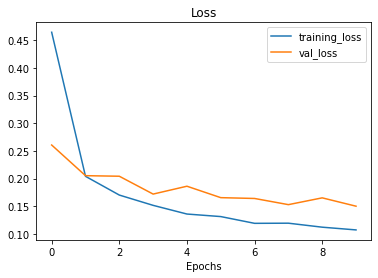

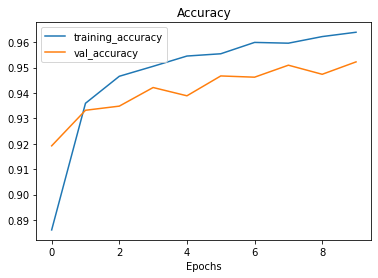

In [ ]:
plot_loss_curves(history_mobileNet_fex)

## **27- Finetuning With MobileNetV2**

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_mobileNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [ ]:
# What layers in the model are trainable?
for layer in model_mobileNet.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
mobilenetv2_1.00_224 True
global_avg_pooling_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(model_mobileNet.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

## **28-Recompile and Evaluate The Model**

In [ ]:
fine_tune_epochs = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_mobileNet_fine_tune = model_mobileNet.fit(train_data,
                                            epochs=20, # fit to 5 epochs to keep experiment quick
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)),
                                            initial_epoch=history_mobileNet_fex.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 94s 58ms/step - loss: 0.1778 - tp: 51717.0000 - fp: 2630.0000 - tn: 2100556.0000 - fn: 3630.0000 - accuracy: 0.9416 - precision: 0.9516 - recall: 0.9344 - auc: 0.9980 - val_loss: 0.0733 - val_tp: 873.0000 - val_fp: 19.0000 - val_tn: 34029.0000 - val_fn: 23.0000 - val_accuracy: 0.9743 - val_precision: 0.9787 - val_recall: 0.9743 - val_auc: 0.9983
Epoch 11/20
1537/1537 [==============================] - 89s 58ms/step - loss: 0.1434 - tp: 46503.0000 - fp: 1983.0000 - tn: 1866819.0000 - fn: 2676.0000 - accuracy: 0.9514 - precision: 0.9591 - recall: 0.9456 - auc: 0.9984 - val_loss: 0.0482 - val_tp: 885.0000 - val_fp: 9.0000 - val_tn: 34039.0000 - val_fn: 11.0000 - val_accuracy: 0.9900 - val_precision: 0.9899 - val_recall: 0.9877 - val_auc: 0.9988
Epoch 12/20
1537/1537 [==============================] - 88s 57ms/step - loss: 0.1230 - tp: 46929.0000 - fp: 1709.0000 - tn: 1867093.0000 - fn: 2250.0000 - accuracy: 0.9593 - precision: 0.964

In [ ]:
result_fine_tune_mobileNet = model_mobileNet.evaluate(test_data)
result_fine_tune_mobileNet

193/193 [==============================] - 10s 52ms/step - loss: 0.1235 - tp: 5920.0000 - fp: 225.0000 - tn: 234159.0000 - fn: 248.0000 - accuracy: 0.9611 - precision: 0.9634 - recall: 0.9598 - auc: 0.9980


[0.12346643209457397,
 5920.0,
 225.0,
 234159.0,
 248.0,
 0.9610894918441772,
 0.9633848667144775,
 0.9597924947738647,
 0.998039960861206]

## **29-Compare Both Histories**

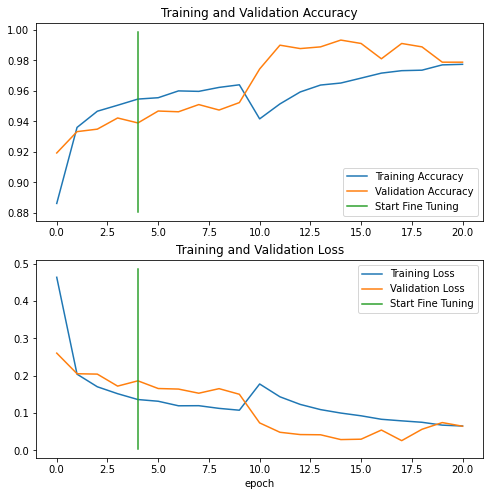

In [ ]:
compare_historys(original_history=history_mobileNet_fex,
                 new_history=history_mobileNet_fine_tune,
                 initial_epochs=5)

## **29-Saving MobileNetV2 Model**

In [ ]:
# # Save our fine-tuning model
# model_mobileNet.save("drive/MyDrive/Project/Mobile_NetV2Model")

## **30-Evaluating All Accross**

In [ ]:
# Make predictions with model
preds_probs_mobileNet = model_mobileNet.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 10s 49ms/step


In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_mobileNet[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_mobileNet[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_mobileNet[0].argmax()}")


Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [9.9922264e-01 8.5420186e-07 1.0896082e-05 2.4908572e-11 1.8350601e-11
 2.3445923e-13 6.9161501e-08 2.1427499e-10 1.0791880e-07 5.8851209e-11
 1.6923224e-09 3.0528793e-12 3.4972564e-07 2.9972242e-09 1.0102926e-06
 1.8763124e-13 8.0681852e-09 1.0150881e-05 6.8876052e-13 7.0974720e-04
 7.6128333e-11 5.8910655e-06 4.0321174e-07 7.1376094e-16 1.2276429e-11
 6.8465172e-13 5.7875056e-08 2.2383355e-09 5.3277778e-11 2.1139685e-06
 6.1788114e-07 1.0878570e-08 3.1872759e-08 1.3222577e-05 9.0352792e-10
 2.1841923e-05 1.0301470e-08 5.5788512e-12 3.8367723e-08]
The class with highest predicted probability by the model for sample 0: 0


In [ ]:
# Get the pred classes of each model
pred_classes_mobileNet = preds_probs_mobileNet.argmax(axis=1)

# How do they look like?
pred_classes_mobileNet[:10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21])

In [ ]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels_mobileNet = []
for images, labels in test_data.unbatch():
  y_labels_mobileNet.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels_mobileNet[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# The results from the saved model (Above) should be very similar to the results below
result_fine_tune_mobileNet

[0.12346643209457397,
 5920.0,
 225.0,
 234159.0,
 248.0,
 0.9610894918441772,
 0.9633848667144775,
 0.9597924947738647,
 0.998039960861206]

In [ ]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust']

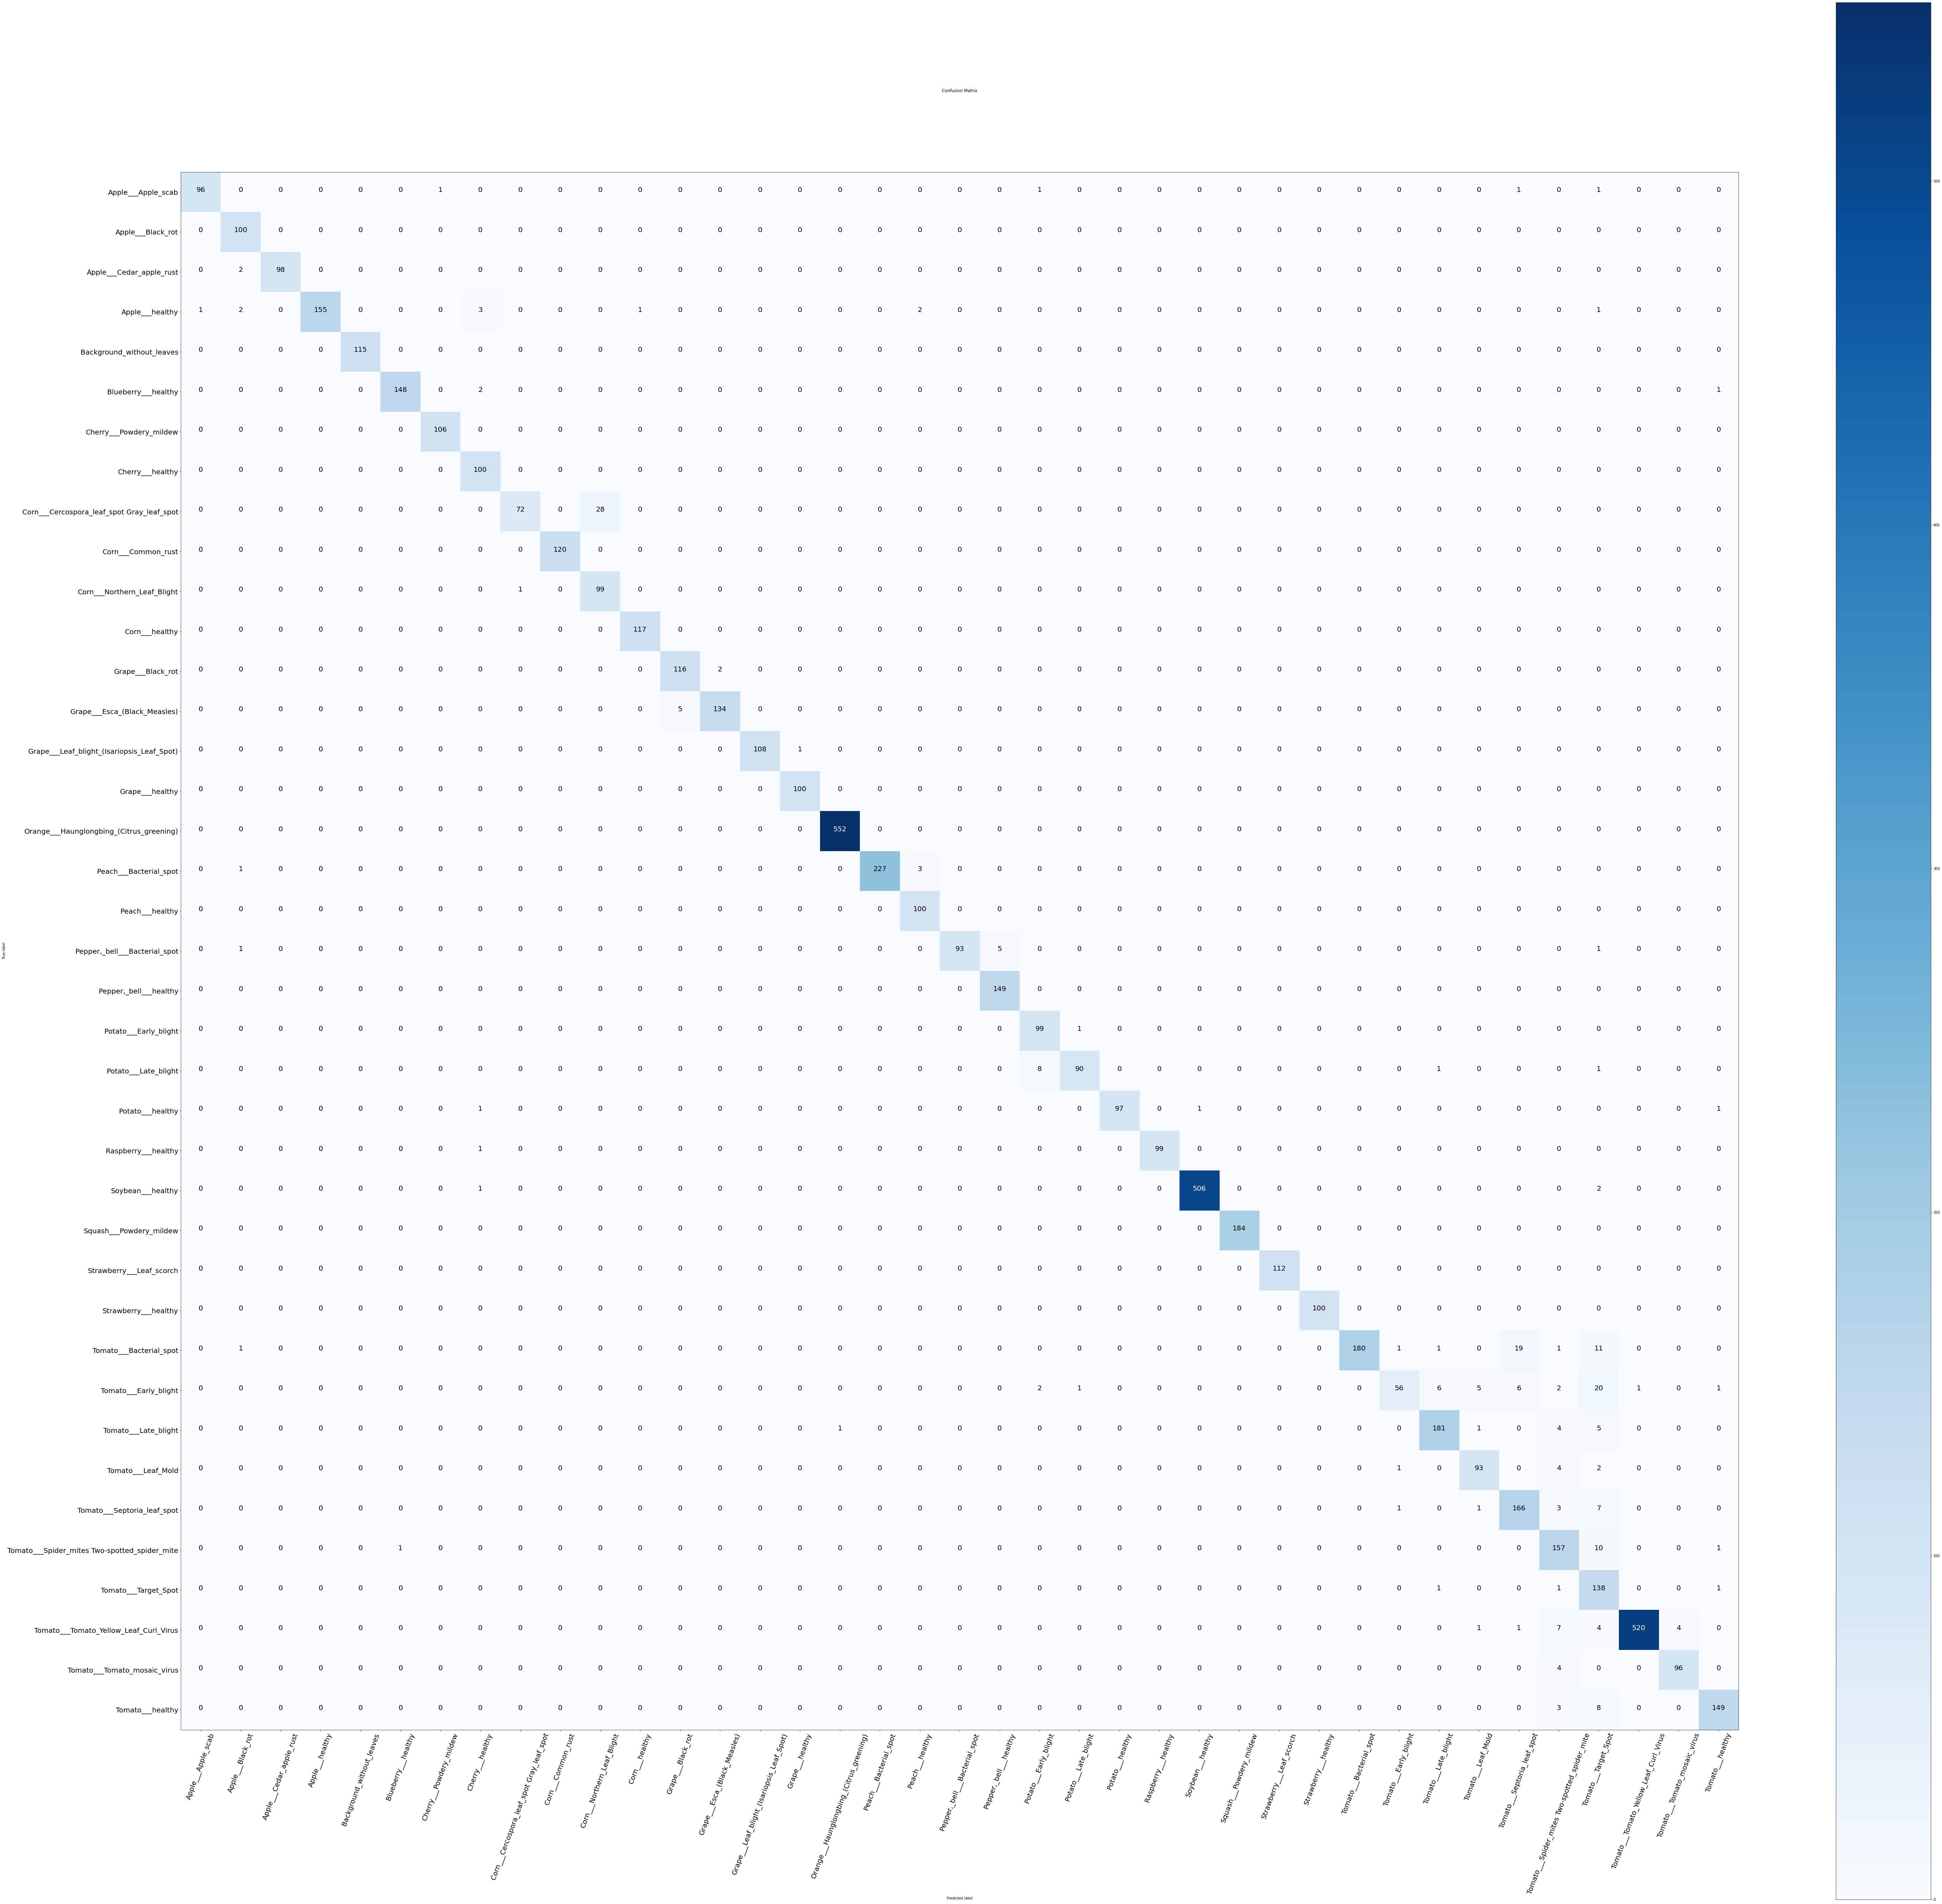

In [ ]:
make_confusion_matrix(y_true=y_labels_mobileNet,
                       y_pred=pred_classes_mobileNet,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## **31-Classification Report of MobileNetV2**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels_mobileNet,
                            y_pred=pred_classes_mobileNet))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.93      1.00      0.97       100
           2       1.00      0.98      0.99       100
           3       1.00      0.94      0.97       165
           4       1.00      1.00      1.00       115
           5       0.99      0.98      0.99       151
           6       0.99      1.00      1.00       106
           7       0.93      1.00      0.96       100
           8       0.99      0.72      0.83       100
           9       1.00      1.00      1.00       120
          10       0.78      0.99      0.87       100
          11       0.99      1.00      1.00       117
          12       0.96      0.98      0.97       118
          13       0.99      0.96      0.97       139
          14       1.00      0.99      1.00       109
          15       0.99      1.00      1.00       100
          16       1.00      1.00      1.00       552
          17       1.00    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict_mobileNet = classification_report(y_labels_mobileNet, pred_classes_mobileNet, output_dict=True)
classification_report_dict_mobileNet

{'0': {'f1-score': 0.9746192893401014,
  'precision': 0.9896907216494846,
  'recall': 0.96,
  'support': 100},
 '1': {'f1-score': 0.966183574879227,
  'precision': 0.9345794392523364,
  'recall': 1.0,
  'support': 100},
 '10': {'f1-score': 0.8722466960352423,
  'precision': 0.7795275590551181,
  'recall': 0.99,
  'support': 100},
 '11': {'f1-score': 0.9957446808510638,
  'precision': 0.9915254237288136,
  'recall': 1.0,
  'support': 117},
 '12': {'f1-score': 0.9707112970711298,
  'precision': 0.9586776859504132,
  'recall': 0.9830508474576272,
  'support': 118},
 '13': {'f1-score': 0.9745454545454545,
  'precision': 0.9852941176470589,
  'recall': 0.9640287769784173,
  'support': 139},
 '14': {'f1-score': 0.9953917050691244,
  'precision': 1.0,
  'recall': 0.9908256880733946,
  'support': 109},
 '15': {'f1-score': 0.9950248756218906,
  'precision': 0.9900990099009901,
  'recall': 1.0,
  'support': 100},
 '16': {'f1-score': 0.9990950226244344,
  'precision': 0.9981916817359855,
  'recal

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict_mobileNet.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Apple___Apple_scab': 0.9746192893401014,
 'Apple___Black_rot': 0.966183574879227,
 'Apple___Cedar_apple_rust': 0.98989898989899,
 'Apple___healthy': 0.96875,
 'Background_without_leaves': 1.0,
 'Blueberry___healthy': 0.9866666666666667,
 'Cherry___Powdery_mildew': 0.9953051643192489,
 'Cherry___healthy': 0.9615384615384615,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 0.8323699421965317,
 'Corn___Common_rust': 1.0,
 'Corn___Northern_Leaf_Blight': 0.8722466960352423,
 'Corn___healthy': 0.9957446808510638,
 'Grape___Black_rot': 0.9707112970711298,
 'Grape___Esca_(Black_Measles)': 0.9745454545454545,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 0.9953917050691244,
 'Grape___healthy': 0.9950248756218906,
 'Orange___Haunglongbing_(Citrus_greening)': 0.9990950226244344,
 'Peach___Bacterial_spot': 0.9912663755458515,
 'Peach___healthy': 0.975609756097561,
 'Pepper,_bell___Bacterial_spot': 0.9637305699481865,
 'Pepper,_bell___healthy': 0.9834983498349835,
 'Potato___Early_blight': 0.9428

In [ ]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores       

class_names  f1-score
9                              Corn___Common_rust  1.000000
4                       Background_without_leaves  1.000000
28                           Strawberry___healthy  1.000000
27                       Strawberry___Leaf_scorch  1.000000
26                        Squash___Powdery_mildew  1.000000
16       Orange___Haunglongbing_(Citrus_greening)  0.999095
25                              Soybean___healthy  0.996063
11                                 Corn___healthy  0.995745
14     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  0.995392
6                         Cherry___Powdery_mildew  0.995305
15                                Grape___healthy  0.995025
24                            Raspberry___healthy  0.994975
17                         Peach___Bacterial_spot  0.991266
2                        Apple___Cedar_apple_rust  0.989899
5                             Blueberry___healthy  0.986667
23                               Potato___healthy  0.984772
20                         Pepper,_bell___healthy  0.983498
36         Tomato___Tomato_Yellow_Leaf_Curl_Virus  0.982987
18                                Peach___healthy  0.975610
0                              Apple___Apple_scab  0.974619
13                   Grape___Esca_(Black_Measles)  0.974545
12                              Grape___Black_rot  0.970711
3                                 Apple___healthy  0.968750
1                               Apple___Black_rot  0.966184
19                  Pepper,_bell___Bacterial_spot  0.963731
7                                Cherry___healthy  0.961538
37                   Tomato___Tomato_mosaic_virus  0.960000
38                               Tomato___healthy  0.949045
31                           Tomato___Late_blight  0.947644
21                          Potato___Early_blight  0.942857
22                           Potato___Late_blight  0.937500
32                             Tomato___Leaf_Mold  0.925373
29                        Tomato___Bacterial_spot  0.913706
33                    Tomato___Septoria_leaf_spot  0.894879
34  Tomato___Spider_mites Two-spotted_spider_mite  0.884507
10                    Corn___Northern_Leaf_Blight  0.872247
8      Corn___Cercospora_leaf_spot Gray_leaf_spot  0.832370
35                           Tomato___Target_Spot  0.784091
30                          Tomato___Early_blight  0.704403

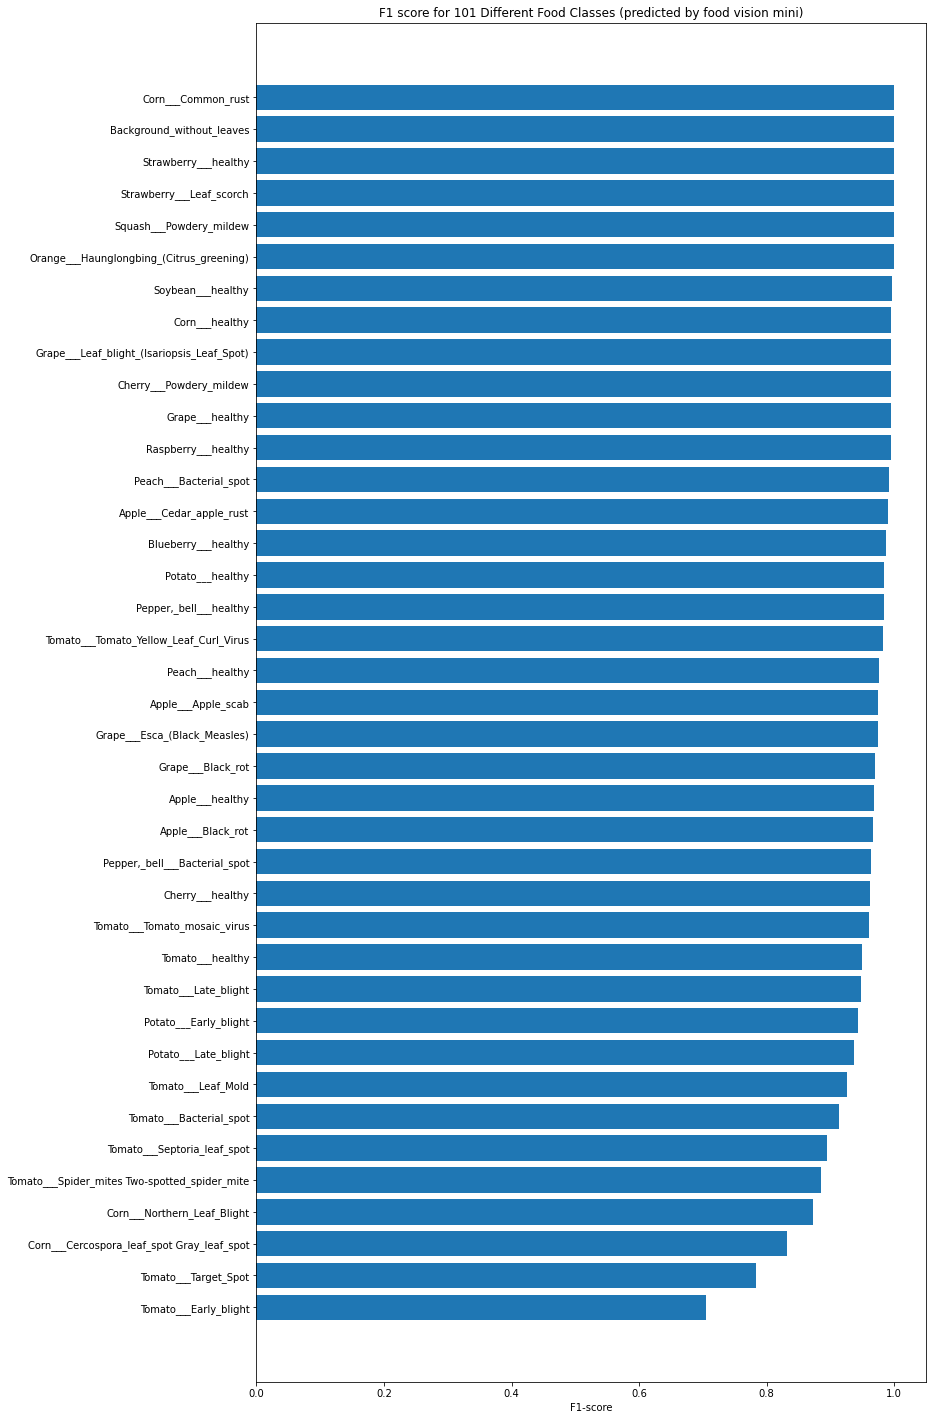

In [ ]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

# **Model 3(EfficientNetV2B3)**

## **32-Data Augmentation**

In [ ]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation_3 = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")

In [ ]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
#x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(inputs, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
x = layers.Dense(1024, activation="sigmoid")(x)
x = layers.Dense(1024, activation="sigmoid")(x)
x = layers.Dense(1024, activation="sigmoid")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_efficientNetB3 = tf.keras.Model(inputs, outputs)

52617216/52606240 [==============================] - 1s 0us/step


In [ ]:
model_efficientNetB3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_avg_pooling_layer (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049

## **33-Compile and Evaluate The Model**

In [ ]:
# Compile
model_efficientNetB3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_efficientNetb3_fex = model_efficientNetB3.fit(train_data,
                                            epochs=10, # fit to 5 epochs to keep experiment quick
                                            validation_data=val_data,
                                            validation_steps=int(0.25 * len(val_data)))

Epoch 1/10
1537/1537 [==============================] - 183s 112ms/step - loss: 0.5315 - tp: 45082.0000 - fp: 3095.0000 - tn: 2100091.0000 - fn: 10265.0000 - accuracy: 0.8557 - precision: 0.9358 - recall: 0.8145 - auc: 0.9943 - val_loss: 0.1982 - val_tp: 1427.0000 - val_fp: 101.0000 - val_tn: 58267.0000 - val_fn: 109.0000 - val_accuracy: 0.9310 - val_precision: 0.9339 - val_recall: 0.9290 - val_auc: 0.9973
Epoch 2/10
1537/1537 [==============================] - 169s 110ms/step - loss: 0.1170 - tp: 47016.0000 - fp: 1649.0000 - tn: 1867153.0000 - fn: 2163.0000 - accuracy: 0.9605 - precision: 0.9661 - recall: 0.9560 - auc: 0.9989 - val_loss: 0.1089 - val_tp: 1473.0000 - val_fp: 58.0000 - val_tn: 58310.0000 - val_fn: 63.0000 - val_accuracy: 0.9616 - val_precision: 0.9621 - val_recall: 0.9590 - val_auc: 0.9986
Epoch 3/10
1537/1537 [==============================] - 169s 110ms/step - loss: 0.0750 - tp: 47835.0000 - fp: 1075.0000 - tn: 1867727.0000 - fn: 1344.0000 - accuracy: 0.9752 - precisi

In [ ]:
result_effientNetb3_fex = model_efficientNetB3.evaluate(test_data)
result_effientNetb3_fex

193/193 [==============================] - 21s 108ms/step - loss: 0.0832 - tp: 6026.0000 - fp: 128.0000 - tn: 234256.0000 - fn: 142.0000 - accuracy: 0.9781 - precision: 0.9792 - recall: 0.9770 - auc: 0.9977


[0.0831727385520935,
 6026.0,
 128.0,
 234256.0,
 142.0,
 0.9781128168106079,
 0.979200541973114,
 0.9769779443740845,
 0.9977288246154785]

## **34-Plot for EfficientNetV2B3**

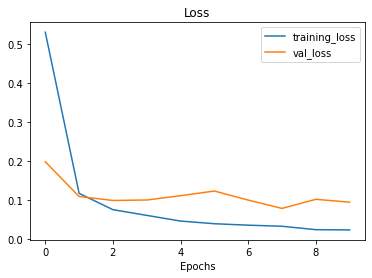

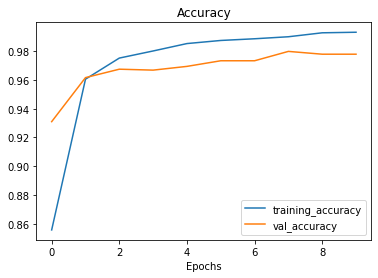

In [ ]:
plot_loss_curves(history_efficientNetb3_fex)

## **35- Fine Tuning With EfficientNetV2B3**

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

## **36-Recompile and Evaluate the Model**

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_efficientNetB3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [ ]:
# What layers in the model are trainable?
for layer in model_efficientNetB3.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b3 True
global_avg_pooling_layer True
dense True
dense_1 True
dense_2 True
output_layer True


In [ ]:
for layer_number, layer in enumerate(model_efficientNetB3.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_add False
13 block2a_expand_conv False
14 block2a_expand_bn False
15 block2a_expand_activation False
16 block2a_project_conv False
17 block2a_project_bn False
18 block2b_expand_conv False
19 block2b_expand_bn False
20 block2b_expand_activation False
21 block2b_project_conv False
22 block2b_project_bn False
23 block2b_add False
24 block2c_expand_conv False
25 block2c_expand_bn False
26 block2c_expand_activation False
27 block2c_project_conv False
28 block2c_project_bn False
29 block2c_add False
30 block3a_expand_conv False
31 block3a_expand_bn False
32 block3a_expand_activation False
33 block3a_project_conv False
34 block3a_project_bn False
35 block3b_expand_conv False
36 block3b

In [ ]:
fine_tune_epochs = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_effNetv2b3_fine_tune = model_efficientNetB3.fit(train_data,
                                                        epochs=fine_tune_epochs, # fit to 5 epochs to keep experiment quick
                                                        validation_data=val_data,
                                                        validation_steps=int(0.25 * len(val_data)),
                                                        initial_epoch=history_efficientNetb3_fex.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 185s 114ms/step - loss: 0.0157 - tp: 54930.0000 - fp: 382.0000 - tn: 2102804.0000 - fn: 417.0000 - accuracy: 0.9928 - precision: 0.9931 - recall: 0.9925 - auc: 0.9996 - val_loss: 0.0844 - val_tp: 1504.0000 - val_fp: 31.0000 - val_tn: 58337.0000 - val_fn: 32.0000 - val_accuracy: 0.9792 - val_precision: 0.9798 - val_recall: 0.9792 - val_auc: 0.9977
Epoch 11/20
1537/1537 [==============================] - 174s 113ms/step - loss: 0.0092 - tp: 49015.0000 - fp: 150.0000 - tn: 1868652.0000 - fn: 164.0000 - accuracy: 0.9967 - precision: 0.9969 - recall: 0.9967 - auc: 0.9999 - val_loss: 0.1308 - val_tp: 1498.0000 - val_fp: 38.0000 - val_tn: 58330.0000 - val_fn: 38.0000 - val_accuracy: 0.9753 - val_precision: 0.9753 - val_recall: 0.9753 - val_auc: 0.9950
Epoch 12/20
1537/1537 [==============================] - 174s 113ms/step - loss: 0.0111 - tp: 48988.0000 - fp: 177.0000 - tn: 1868625.0000 - fn: 191.0000 - accuracy: 0.9963 - precision: 0.

In [ ]:
result_fine_tune_efficientNetv2b3 = model_efficientNetB3.evaluate(test_data)
result_fine_tune_efficientNetv2b3

193/193 [==============================] - 21s 106ms/step - loss: 0.0549 - tp: 6090.0000 - fp: 74.0000 - tn: 234310.0000 - fn: 78.0000 - accuracy: 0.9874 - precision: 0.9880 - recall: 0.9874 - auc: 0.9983


[0.05485757440328598,
 6090.0,
 74.0,
 234310.0,
 78.0,
 0.9873540997505188,
 0.9879947900772095,
 0.9873540997505188,
 0.9982516765594482]

## **37-Compare Histories**

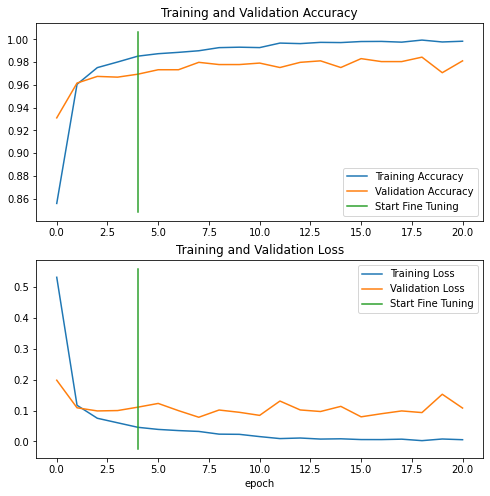

In [ ]:
compare_historys(original_history=history_efficientNetb3_fex,
                 new_history=history_effNetv2b3_fine_tune,
                 initial_epochs=5)

## **38-Save and Load the Model**

In [ ]:
# model_efficientNetB3.save("drive/MyDrive/tensorflow_course/Project/EfficientNetV2B3Model")

In [ ]:
# model_efficientNetB3.save("my_model.h5")

In [ ]:
# from keras.models import load_model

In [ ]:
# loaded_model = load_model('my_model.h5')

In [ ]:
# loaded_model.evaluate(test_data)

## **39-Make Predictions With Model**

In [ ]:
# Make predictions with model
preds_probs_efcNetV2 = model_efficientNetB3.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 21s 100ms/step


In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_efcNetV2[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_efcNetV2[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_efcNetV2[0].argmax()}")

Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [9.3753380e-01 2.5908384e-06 1.0705296e-06 2.1372024e-04 1.8881998e-08
 2.5134999e-09 6.2209558e-02 1.1703383e-09 9.0654602e-08 6.2611322e-10
 9.6232050e-08 2.0894080e-09 6.0881768e-12 2.5278037e-12 1.4317761e-11
 2.9474562e-11 5.8855210e-08 3.3757260e-05 2.3589019e-08 4.7725649e-07
 4.1512949e-11 1.2690800e-09 2.8455390e-06 1.2318052e-08 4.5989186e-09
 7.1773725e-09 1.3389931e-06 1.4047595e-09 1.5565049e-10 6.4849828e-09
 2.9864154e-07 2.1919688e-07 9.7964117e-09 3.0857898e-09 6.7039413e-10
 3.2542028e-11 6.6165774e-11 2.0857964e-09 8.5088065e-12]
The class with highest predicted probability by the model for sample 0: 0


In [ ]:
# Get the pred classes of each model
pred_classes_efcNetV2 = preds_probs_efcNetV2.argmax(axis=1)

# How do they look like?
pred_classes_efcNetV2[:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels_efcNet = []
for images, labels in test_data.unbatch():
  y_labels_efcNet.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels_efcNet[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## **40-Create Confusion Matrix**

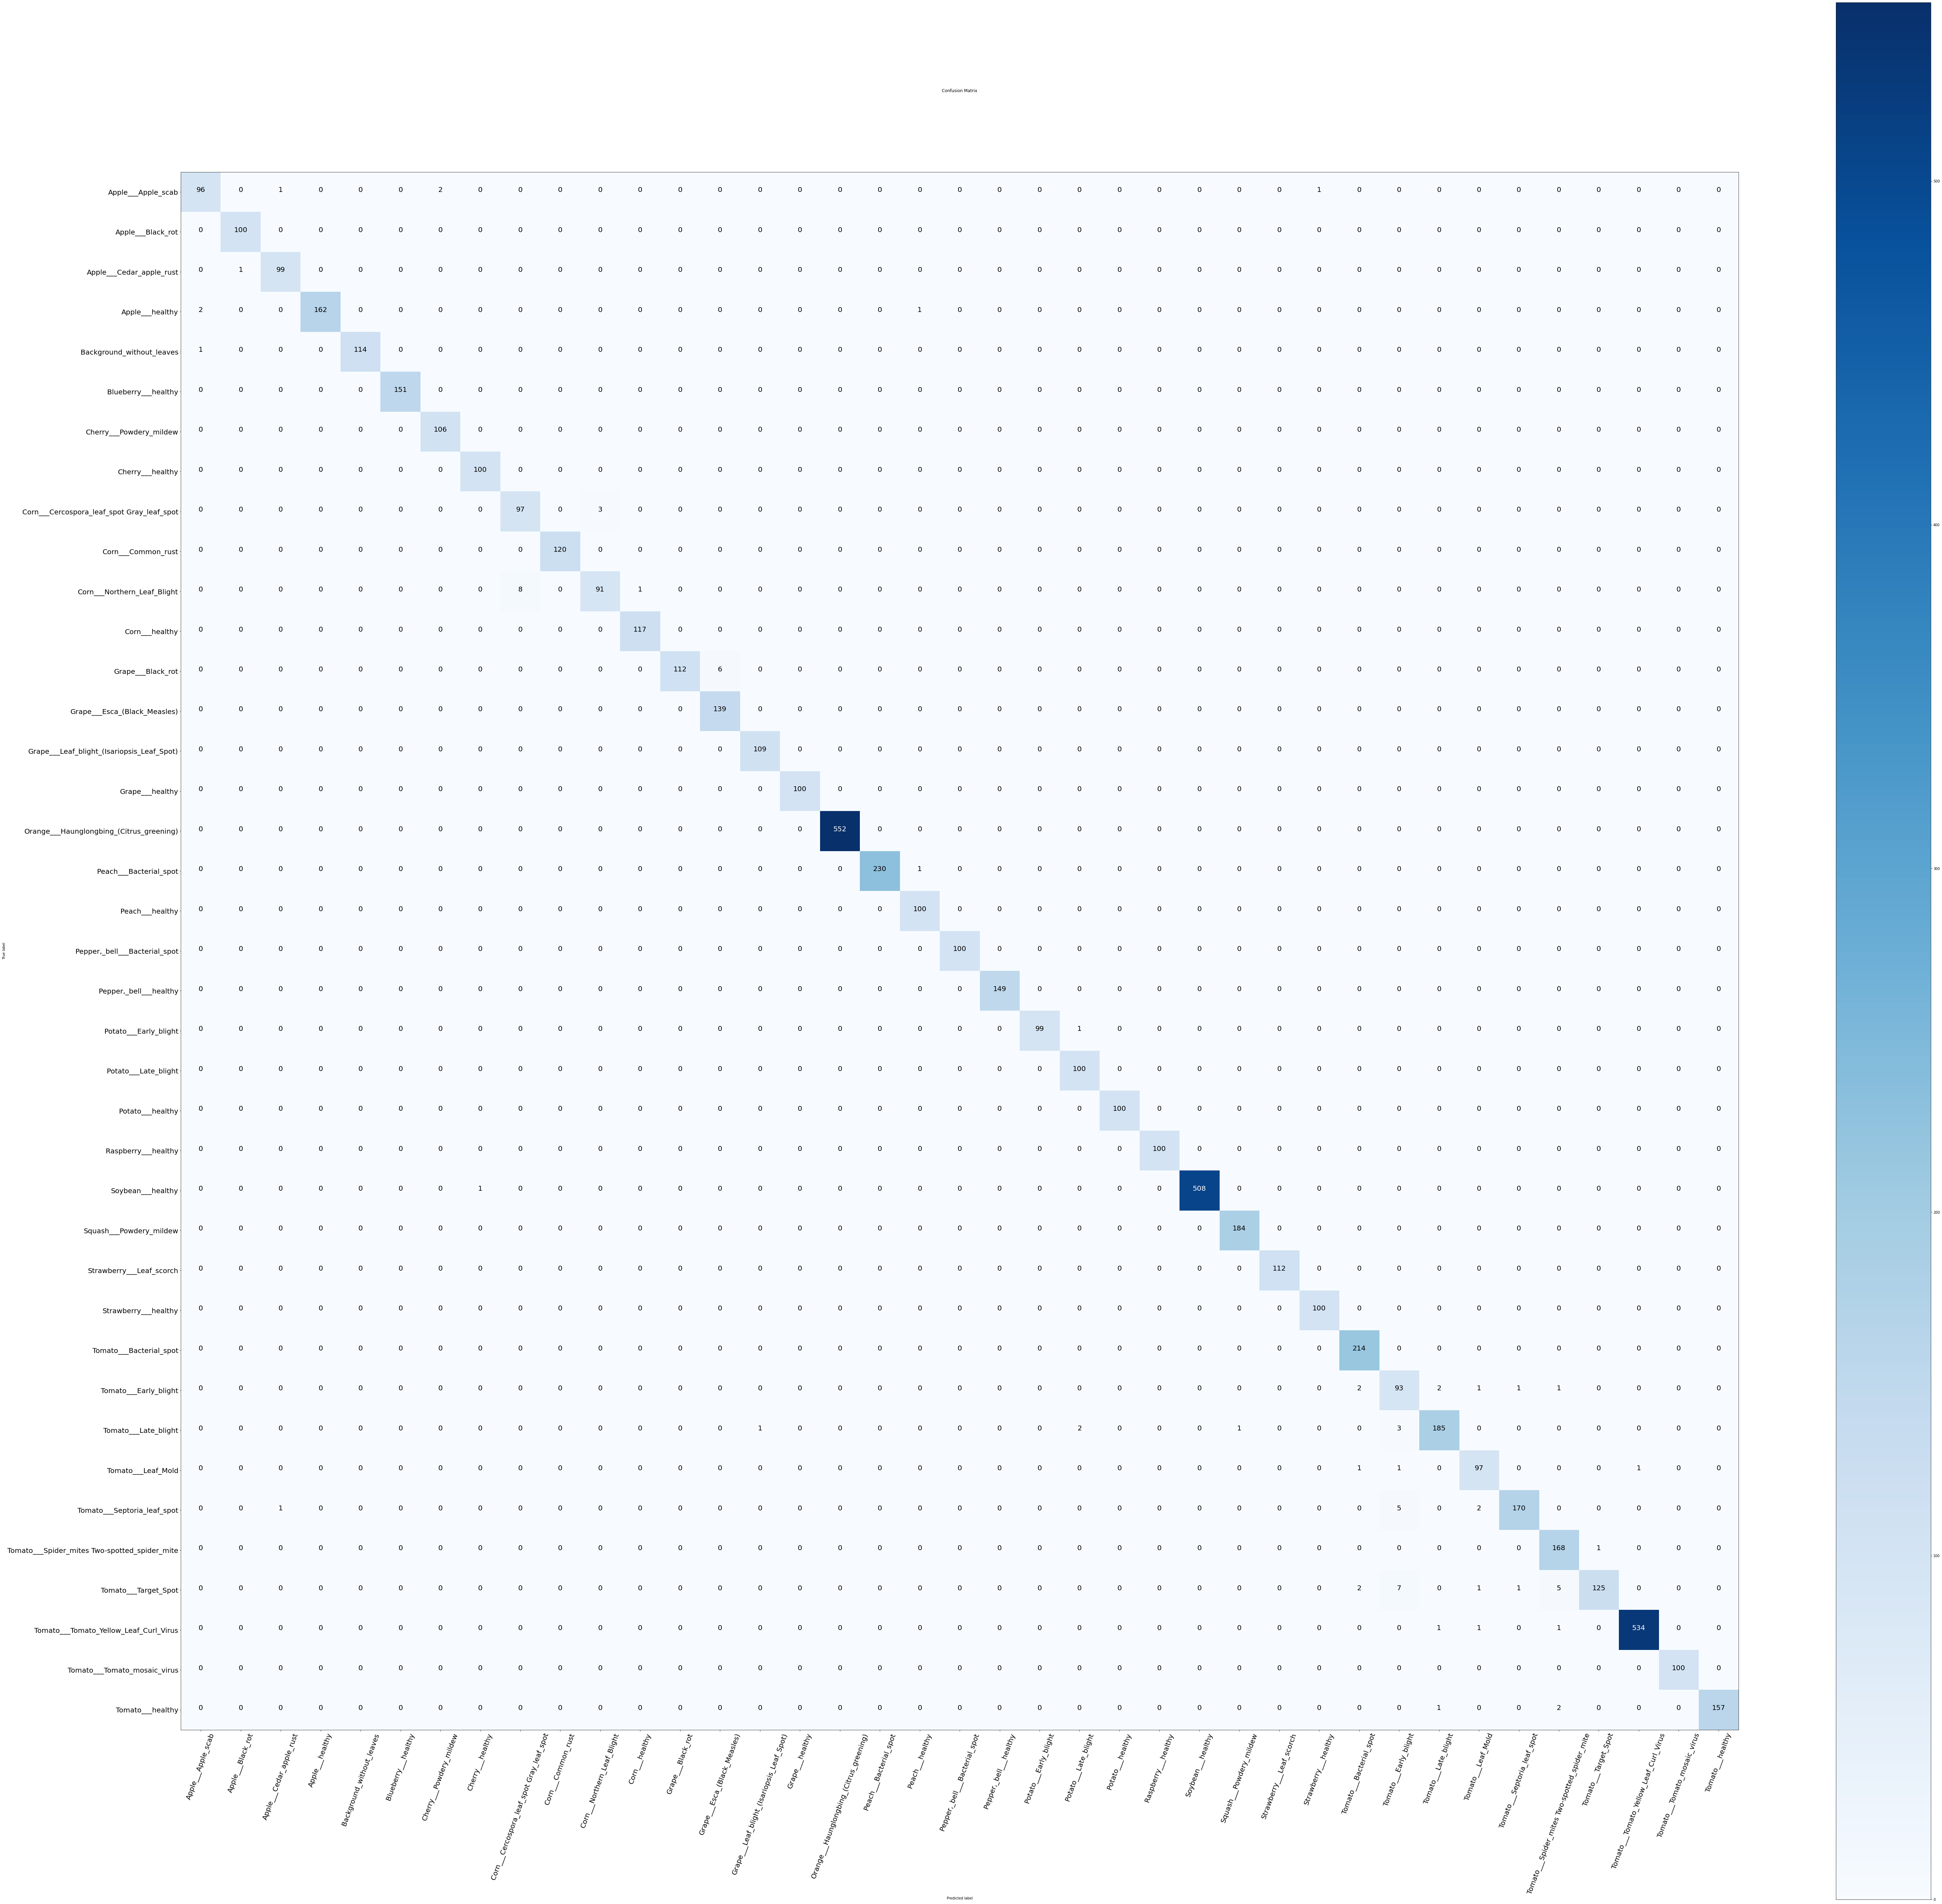

In [ ]:
make_confusion_matrix(y_true=y_labels_efcNet,
                       y_pred=pred_classes_efcNetV2,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

# **Model 4 (RESNET50)**

## **41-Data Augmentation**

In [16]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation_4 = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")


## **42-Compile and Evaluate RESNET50 Model**

In [17]:
# Setup a base model and freeze its layer (this will extract features)
base_model_4 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
base_model_4.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation_4(inputs) # augment layers (only happens during trainable phase)
x = base_model_4(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_4=tf.keras.Model(inputs, outputs)

94781440/94765736 [==============================] - 1s 0us/step


In [18]:
# Get a summary of model we've been created
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_avg_pooling_layer (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 39)                79911     
                                                                 
Total params: 23,667,623
Trainable params: 79,911
Non-trainab

In [19]:
from tensorflow.keras import metrics

In [20]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [22]:
# Compile
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_4 = model_4.fit(train_data,
                    epochs=10, # fit to 5 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/10
1537/1537 [==============================] - 449s 289ms/step - loss: 3.5629 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1911362.0000 - fn: 50299.0000 - accuracy: 0.0932 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6295 - val_loss: 3.4491 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 233282.0000 - val_fn: 6139.0000 - val_accuracy: 0.0881 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6700
Epoch 2/10
1537/1537 [==============================] - 297s 193ms/step - loss: 3.4937 - tp: 1.0000 - fp: 1.0000 - tn: 1868801.0000 - fn: 49178.0000 - accuracy: 0.1121 - precision: 0.5000 - recall: 2.0334e-05 - auc: 0.6543 - val_loss: 3.4007 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 233282.0000 - val_fn: 6139.0000 - val_accuracy: 0.0958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6848
Epoch 3/10
1537/1537 [==============================] - 281s 183ms/step - loss: 3.4425 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1868802.0000 - fn: 49

In [23]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model_4.evaluate(test_data)
feature_extraction_results

193/193 [==============================] - 21s 108ms/step - loss: 3.1360 - tp: 0.0000e+00 - fp: 5.0000 - tn: 234379.0000 - fn: 6168.0000 - accuracy: 0.2113 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7630


[3.13600754737854,
 0.0,
 5.0,
 234379.0,
 6168.0,
 0.2112516164779663,
 0.0,
 0.0,
 0.7629897594451904]

## **43- Plot the Graph for RESNET50**

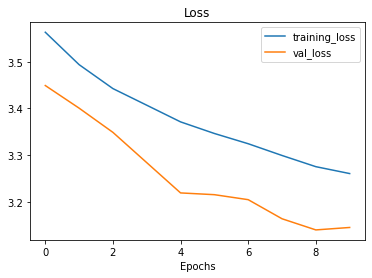

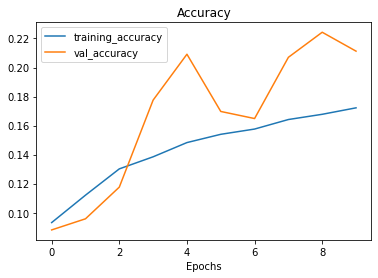

In [24]:
plot_loss_curves(history_4)

## **44- Fine-Tune Model With RESNET50**

In [25]:
# Unfreeze all of the layers in base model
base_model_4.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model_4.layers[:-5]:
  layer.trainable=False

In [26]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [27]:
# What layers in the model are trainable?
for layer in model_4.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
resnet50 True
global_avg_pooling_layer True
output_layer True


In [28]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model_4.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

## **45-Recompile and Evaluate The Model**

In [29]:
# Fine-tune for more 5 epochs
fine_tune_epochs_4 = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune_4 = model_4.fit(train_data,
                              epochs=fine_tune_epochs_4,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history_4.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 246s 156ms/step - loss: 3.2303 - tp: 197.0000 - fp: 270.0000 - tn: 2102916.0000 - fn: 55150.0000 - accuracy: 0.1693 - precision: 0.4218 - recall: 0.0036 - auc: 0.7460 - val_loss: 3.0884 - val_tp: 162.0000 - val_fp: 28.0000 - val_tn: 233254.0000 - val_fn: 5977.0000 - val_accuracy: 0.1836 - val_precision: 0.8526 - val_recall: 0.0264 - val_auc: 0.7842
Epoch 11/20
1537/1537 [==============================] - 233s 151ms/step - loss: 3.1280 - tp: 306.0000 - fp: 202.0000 - tn: 1868600.0000 - fn: 48873.0000 - accuracy: 0.1898 - precision: 0.6024 - recall: 0.0062 - auc: 0.7697 - val_loss: 3.1488 - val_tp: 300.0000 - val_fp: 143.0000 - val_tn: 233139.0000 - val_fn: 5839.0000 - val_accuracy: 0.1647 - val_precision: 0.6772 - val_recall: 0.0489 - val_auc: 0.7767
Epoch 12/20
1537/1537 [==============================] - 233s 151ms/step - loss: 3.0747 - tp: 540.0000 - fp: 323.0000 - tn: 1868479.0000 - fn: 48639.0000 - accuracy: 0.1997 - precisio

In [30]:
# Evaluate on the whole test dataset
fine_tune_results =model_4.evaluate(test_data)
fine_tune_results

193/193 [==============================] - 20s 105ms/step - loss: 2.8212 - tp: 381.0000 - fp: 162.0000 - tn: 234222.0000 - fn: 5787.0000 - accuracy: 0.2850 - precision: 0.7017 - recall: 0.0618 - auc: 0.8238


[2.821244478225708,
 381.0,
 162.0,
 234222.0,
 5787.0,
 0.2850194573402405,
 0.7016574740409851,
 0.06177042797207832,
 0.8238257169723511]

## **46-Compare The Histories**

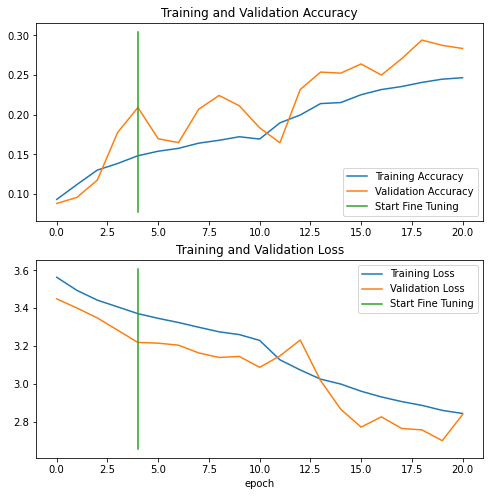

In [31]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_4,
                 new_history=history_fine_tune_4,
                 initial_epochs=5)

## **47-Make Predictions with RESNET50 Model**

In [32]:
# Make predictions with model
preds_probs_4 = model_4.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 20s 101ms/step


In [33]:
len(test_data)

193

In [34]:
# How many predictions are there?
len(preds_probs_4)

6168

In [35]:
# What's the shape of our predictions?
preds_probs_4.shape

(6168, 39)

In [36]:
# Let's see whats the first 10 predictions looks like
preds_probs_4[:10]

array([[1.62394578e-03, 5.28226327e-03, 4.66814527e-04, 3.74000380e-03,
        3.09804250e-02, 1.26597881e-01, 4.66324436e-03, 6.83685532e-04,
        4.07991838e-03, 3.75086674e-04, 8.97128775e-04, 3.02775443e-04,
        2.23833043e-02, 5.10814078e-02, 1.08840866e-02, 2.02227078e-04,
        2.54544248e-05, 4.59497888e-03, 3.29520889e-02, 1.60738360e-02,
        2.01914757e-02, 3.17776739e-03, 6.12378772e-03, 6.31332584e-03,
        9.57499631e-03, 1.26008189e-03, 5.27237076e-04, 2.71730907e-02,
        4.97099478e-03, 2.77553860e-04, 2.05522813e-02, 4.17807102e-02,
        2.03880742e-02, 5.74721172e-02, 1.93889529e-01, 1.13723293e-01,
        2.47857627e-02, 4.05803509e-02, 8.93469602e-02],
       [2.33316384e-02, 1.70595888e-02, 3.02949976e-02, 5.75962625e-02,
        5.46438061e-03, 2.54725721e-02, 2.14567464e-02, 4.63623703e-02,
        8.07012618e-03, 1.08424751e-02, 1.09562278e-02, 1.16854142e-02,
        4.16175351e-02, 1.04889404e-02, 1.65865403e-02, 2.61964742e-02,
       

In [37]:
# What does the first prediction probability array look like?
preds_probs_4[0], len(preds_probs_4[0]), sum(preds_probs_4[0])

(array([1.6239458e-03, 5.2822633e-03, 4.6681453e-04, 3.7400038e-03,
        3.0980425e-02, 1.2659788e-01, 4.6632444e-03, 6.8368553e-04,
        4.0799184e-03, 3.7508667e-04, 8.9712878e-04, 3.0277544e-04,
        2.2383304e-02, 5.1081408e-02, 1.0884087e-02, 2.0222708e-04,
        2.5454425e-05, 4.5949789e-03, 3.2952089e-02, 1.6073836e-02,
        2.0191476e-02, 3.1777674e-03, 6.1237877e-03, 6.3133258e-03,
        9.5749963e-03, 1.2600819e-03, 5.2723708e-04, 2.7173091e-02,
        4.9709948e-03, 2.7755386e-04, 2.0552281e-02, 4.1780710e-02,
        2.0388074e-02, 5.7472117e-02, 1.9388953e-01, 1.1372329e-01,
        2.4785763e-02, 4.0580351e-02, 8.9346960e-02], dtype=float32),
 39,
 0.9999999462997948)

In [38]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_4[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_4[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_4[0].argmax()}")

Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [1.6239458e-03 5.2822633e-03 4.6681453e-04 3.7400038e-03 3.0980425e-02
 1.2659788e-01 4.6632444e-03 6.8368553e-04 4.0799184e-03 3.7508667e-04
 8.9712878e-04 3.0277544e-04 2.2383304e-02 5.1081408e-02 1.0884087e-02
 2.0222708e-04 2.5454425e-05 4.5949789e-03 3.2952089e-02 1.6073836e-02
 2.0191476e-02 3.1777674e-03 6.1237877e-03 6.3133258e-03 9.5749963e-03
 1.2600819e-03 5.2723708e-04 2.7173091e-02 4.9709948e-03 2.7755386e-04
 2.0552281e-02 4.1780710e-02 2.0388074e-02 5.7472117e-02 1.9388953e-01
 1.1372329e-01 2.4785763e-02 4.0580351e-02 8.9346960e-02]
The class with highest predicted probability by the model for sample 0: 34


In [39]:
# Get the pred classes of each model
pred_classes_4 = preds_probs_4.argmax(axis=1)

# How do they look like?
pred_classes_4[:10]

array([34, 16, 16,  4, 20, 31, 25, 36, 36, 16])

In [40]:
# How many pred classes we have?
len(pred_classes_4)

6168

In [41]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
# How many y_labels are there?
len(y_labels)

6168

In [43]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[2.821244478225708,
 381.0,
 162.0,
 234222.0,
 5787.0,
 0.2850194573402405,
 0.7016574740409851,
 0.06177042797207832,
 0.8238257169723511]

In [44]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust']

## **48-Make Confusion Matrix For RESNET50**

In [45]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

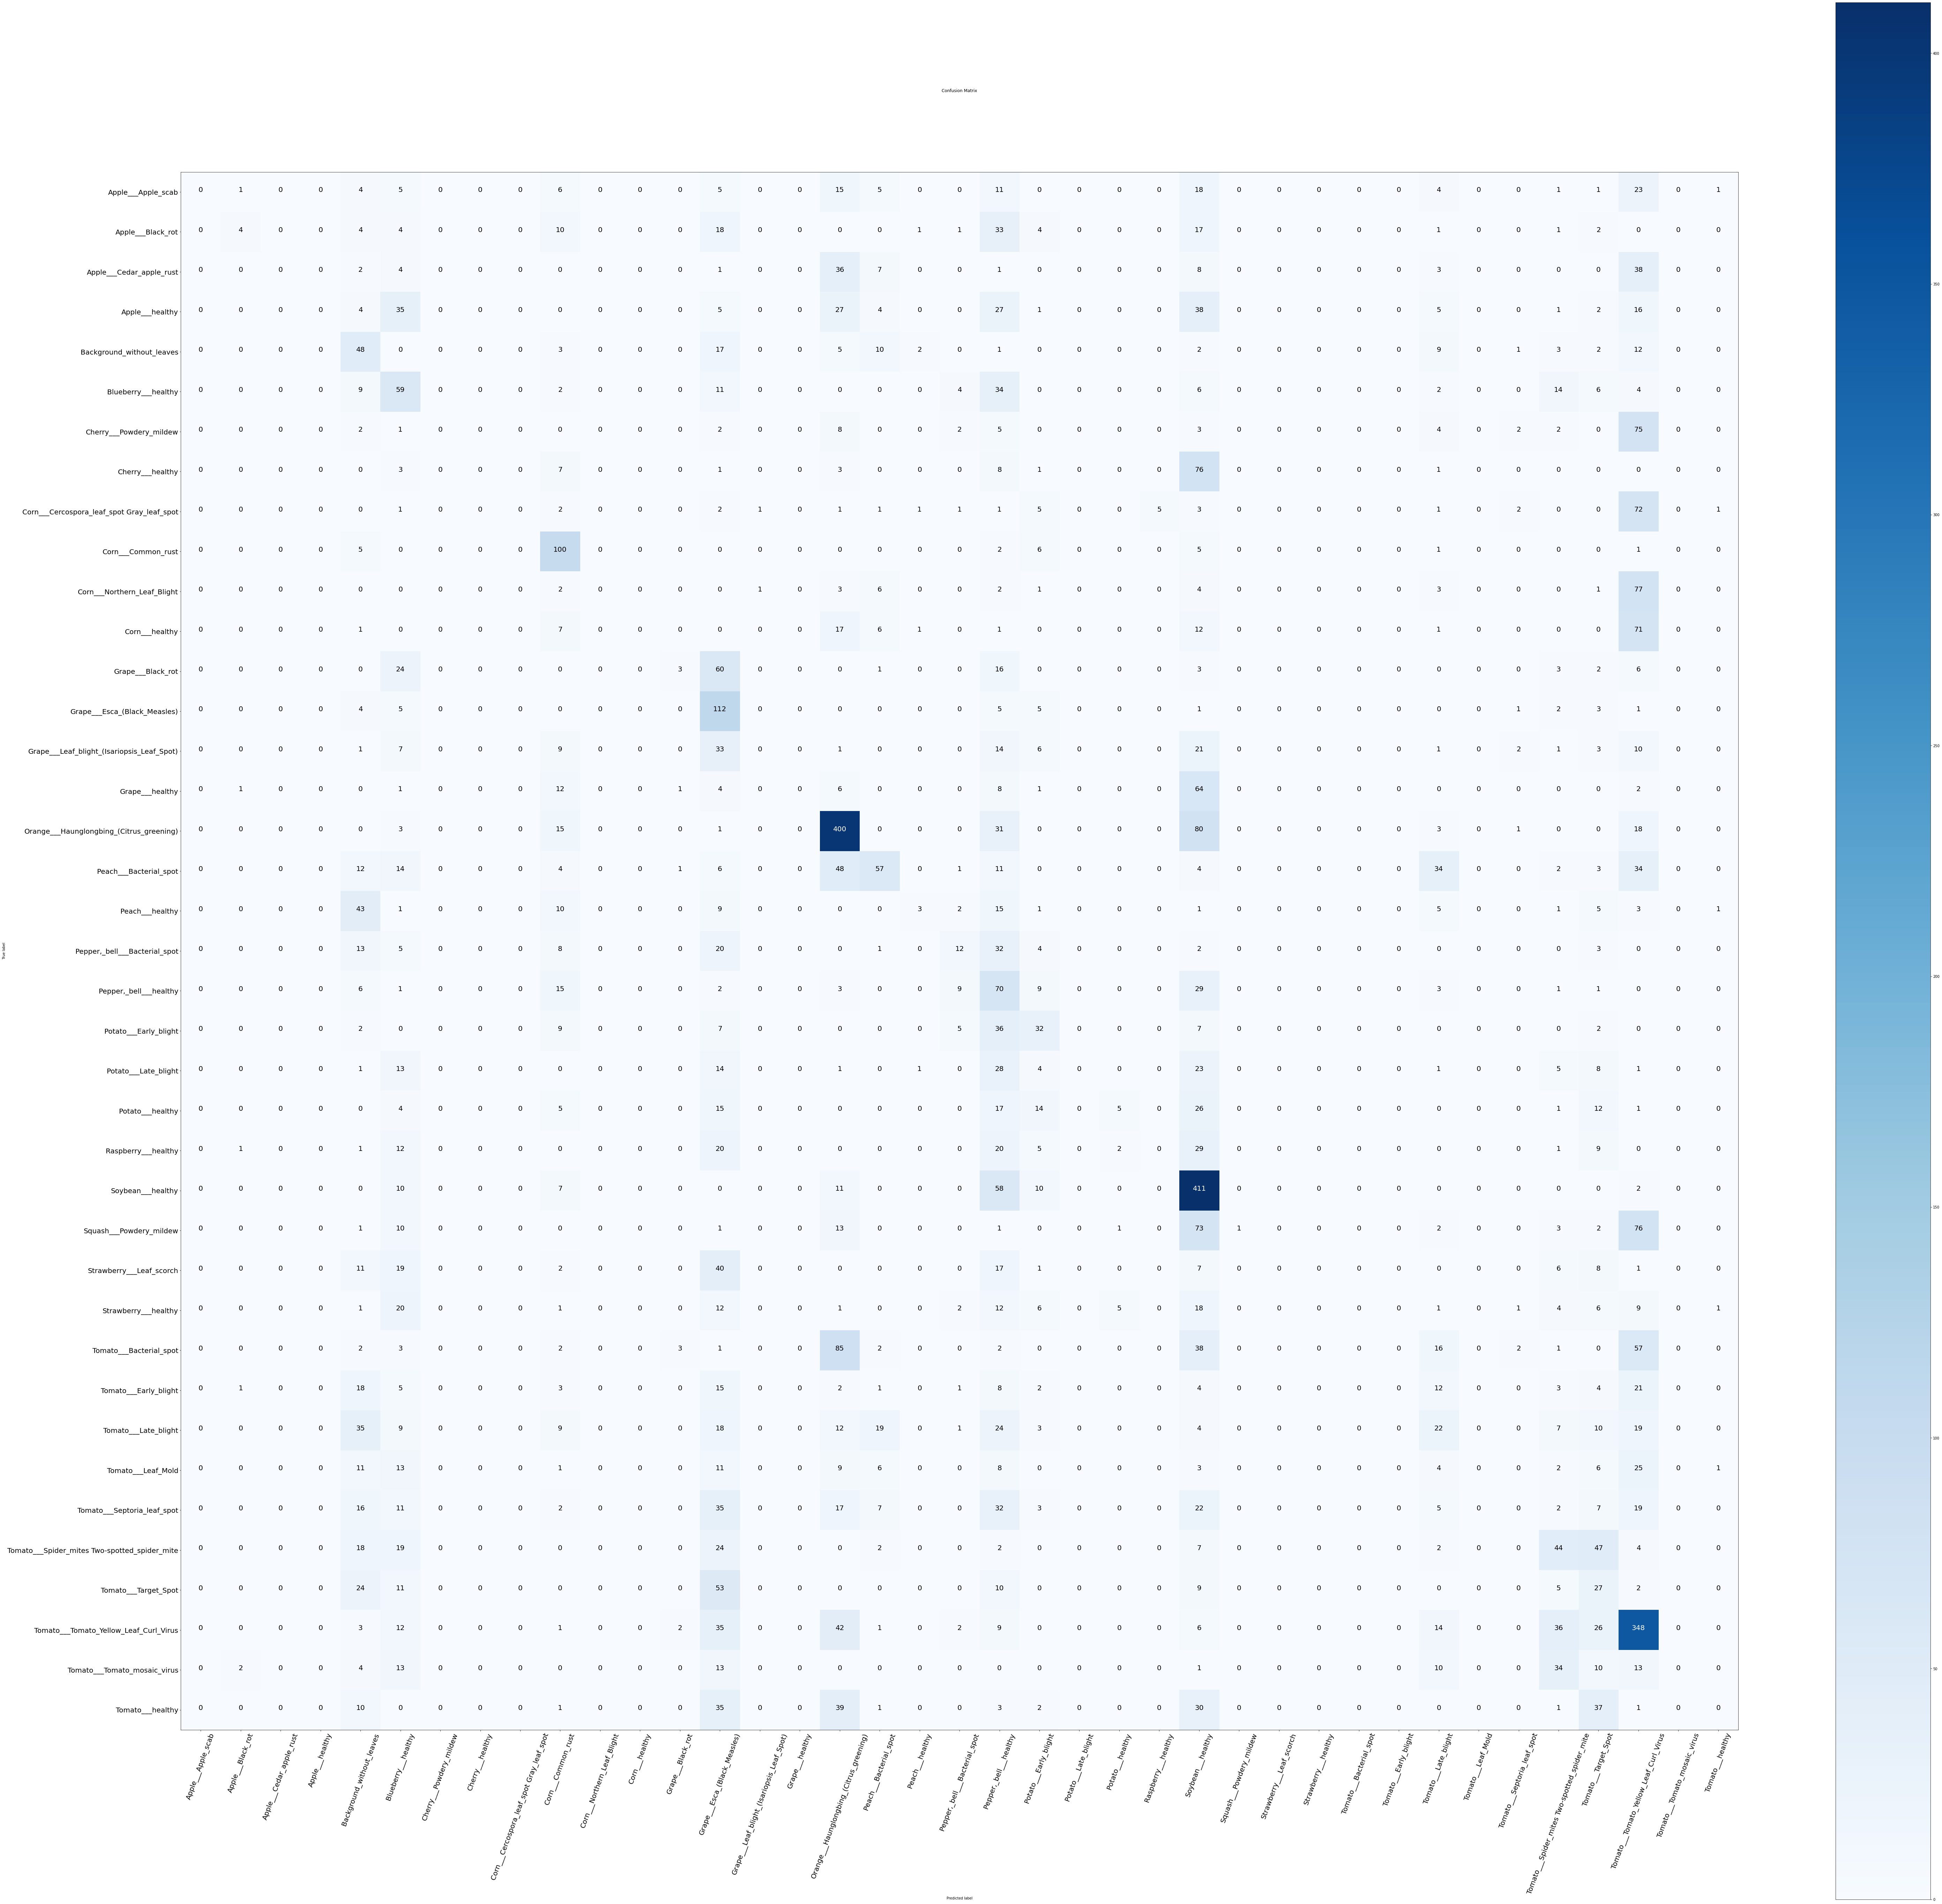

In [46]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes_4,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

# **Model 5 (DenseNET121)**

## **49- Compile and Evaluate the Model**

In [ ]:
# Setup a base model and freeze its layer (this will extract features)
base_model_5 = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet')
base_model_5.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model_5(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_5=tf.keras.Model(inputs, outputs)

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
# Get a summary of model we've been created
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_avg_pooling_layer (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 39)                39975     
                                                                 
Total params: 7,077,479
Trainable params: 39,975
Non-traina

In [ ]:
# Compile
model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_5 = model_5.fit(train_data,
                    epochs=10, # fit to 5 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/10
1537/1537 [==============================] - 624s 400ms/step - loss: 1.2468 - tp: 26252.0000 - fp: 5375.0000 - tn: 2332195.0000 - fn: 35263.0000 - accuracy: 0.5309 - precision: 0.8301 - recall: 0.4268 - auc: 0.9222 - val_loss: 1.6470 - val_tp: 3195.0000 - val_fp: 1532.0000 - val_tn: 231750.0000 - val_fn: 2944.0000 - val_accuracy: 0.5823 - val_precision: 0.6759 - val_recall: 0.5204 - val_auc: 0.9387
Epoch 2/10
1537/1537 [==============================] - 278s 180ms/step - loss: 0.6896 - tp: 35572.0000 - fp: 5090.0000 - tn: 1863712.0000 - fn: 13607.0000 - accuracy: 0.7950 - precision: 0.8748 - recall: 0.7233 - auc: 0.9881 - val_loss: 1.5517 - val_tp: 3521.0000 - val_fp: 1511.0000 - val_tn: 231771.0000 - val_fn: 2618.0000 - val_accuracy: 0.6218 - val_precision: 0.6997 - val_recall: 0.5735 - val_auc: 0.9424
Epoch 3/10
1537/1537 [==============================] - 252s 164ms/step - loss: 0.5982 - tp: 37768.0000 - fp: 5193.0000 - tn: 1863609.0000 - fn: 11411.0000 - accuracy: 0.8189

In [ ]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_denseNet_results = model_5.evaluate(test_data)
feature_extraction_denseNet_results

193/193 [==============================] - 21s 108ms/step - loss: 1.7367 - tp: 3825.0000 - fp: 1744.0000 - tn: 232640.0000 - fn: 2343.0000 - accuracy: 0.6435 - precision: 0.6868 - recall: 0.6201 - auc: 0.9292


[1.7367305755615234,
 3825.0,
 1744.0,
 232640.0,
 2343.0,
 0.643482506275177,
 0.6868378520011902,
 0.6201362013816833,
 0.9291898608207703]

## **50-Plot Graph for DenseNet121**

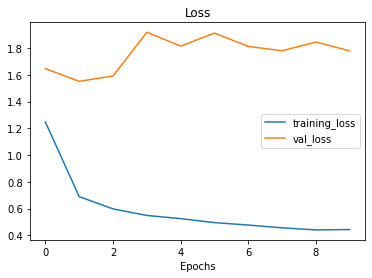

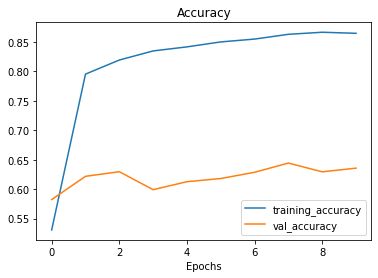

In [ ]:
plot_loss_curves(history_5)

## **51-Fine Tune DenseNet121 Model**

In [ ]:
# Unfreeze all of the layers in base model
base_model_5.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model_5.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [ ]:
# What layers in the model are trainable?
for layer in model_5.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
densenet121 True
global_avg_pooling_layer True
output_layer True


In [ ]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model_5.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_5 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

## **52-Recompile and Evaluate The Model**

In [ ]:
# Fine-tune for more 5 epochs
fine_tune_epochs_5 = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune_5 = model_5.fit(train_data,
                              epochs=fine_tune_epochs_5,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history_5.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 216s 136ms/step - loss: 0.3229 - tp: 46951.0000 - fp: 5144.0000 - tn: 2098042.0000 - fn: 8396.0000 - accuracy: 0.8713 - precision: 0.9013 - recall: 0.8483 - auc: 0.9884 - val_loss: 1.4855 - val_tp: 4048.0000 - val_fp: 1479.0000 - val_tn: 231803.0000 - val_fn: 2091.0000 - val_accuracy: 0.6846 - val_precision: 0.7324 - val_recall: 0.6594 - val_auc: 0.9424
Epoch 11/20
1537/1537 [==============================] - 201s 131ms/step - loss: 0.3008 - tp: 43468.0000 - fp: 3268.0000 - tn: 1865534.0000 - fn: 5711.0000 - accuracy: 0.9048 - precision: 0.9301 - recall: 0.8839 - auc: 0.9962 - val_loss: 1.4819 - val_tp: 4065.0000 - val_fp: 1474.0000 - val_tn: 231808.0000 - val_fn: 2074.0000 - val_accuracy: 0.6858 - val_precision: 0.7339 - val_recall: 0.6622 - val_auc: 0.9432
Epoch 12/20
1537/1537 [==============================] - 199s 130ms/step - loss: 0.3029 - tp: 43505.0000 - fp: 3299.0000 - tn: 1865503.0000 - fn: 5674.0000 - accuracy: 0.9056

In [ ]:
# Evaluate on the whole test dataset
fine_tune_dense_results =model_5.evaluate(test_data)
fine_tune_dense_results

193/193 [==============================] - 20s 101ms/step - loss: 1.3778 - tp: 4167.0000 - fp: 1516.0000 - tn: 232868.0000 - fn: 2001.0000 - accuracy: 0.6984 - precision: 0.7332 - recall: 0.6756 - auc: 0.9480


[1.377848744392395,
 4167.0,
 1516.0,
 232868.0,
 2001.0,
 0.698443591594696,
 0.733239471912384,
 0.6755836606025696,
 0.9479602575302124]

## **53-Compare The Histories**

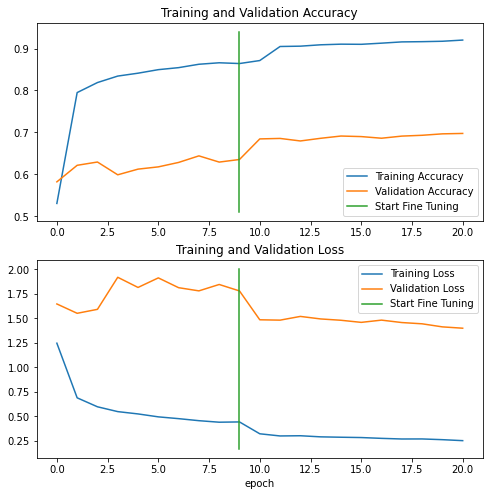

In [ ]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_5,
                 new_history=history_fine_tune_5,
                 initial_epochs=10)

## **54-Make Predictions**

In [ ]:
# Make predictions with model
preds_probs_5 = model_5.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 20s 94ms/step


In [ ]:
# What does the first prediction probability array look like?
preds_probs_5[0], len(preds_probs_5[0]), sum(preds_probs_5[0])

(array([7.56417572e-01, 5.60522117e-02, 1.56600422e-09, 2.31910143e-02,
        9.15864096e-09, 5.88079391e-04, 2.92819067e-07, 6.17847309e-06,
        1.30841684e-07, 4.98899446e-08, 3.08485287e-05, 1.35134223e-06,
        3.20523341e-08, 4.67580712e-08, 8.85209753e-11, 7.34340011e-09,
        2.26920588e-06, 3.00278276e-04, 3.62837516e-09, 7.17907733e-06,
        1.76741094e-06, 4.12857375e-08, 9.71433328e-05, 2.93231096e-06,
        1.02055205e-11, 1.60386637e-02, 4.79208975e-04, 1.13310527e-07,
        1.46173149e-01, 3.54846247e-06, 3.71771336e-10, 4.19632379e-05,
        2.78483583e-07, 5.62895613e-04, 4.65512045e-07, 2.78045569e-08,
        8.49991011e-09, 8.34462915e-11, 2.16290445e-07], dtype=float32),
 39,
 0.9999999809430301)

In [ ]:
# What does the first prediction probability array look like?
preds_probs_5[0], len(preds_probs_5[0]), sum(preds_probs_5[0])

(array([7.56417572e-01, 5.60522117e-02, 1.56600422e-09, 2.31910143e-02,
        9.15864096e-09, 5.88079391e-04, 2.92819067e-07, 6.17847309e-06,
        1.30841684e-07, 4.98899446e-08, 3.08485287e-05, 1.35134223e-06,
        3.20523341e-08, 4.67580712e-08, 8.85209753e-11, 7.34340011e-09,
        2.26920588e-06, 3.00278276e-04, 3.62837516e-09, 7.17907733e-06,
        1.76741094e-06, 4.12857375e-08, 9.71433328e-05, 2.93231096e-06,
        1.02055205e-11, 1.60386637e-02, 4.79208975e-04, 1.13310527e-07,
        1.46173149e-01, 3.54846247e-06, 3.71771336e-10, 4.19632379e-05,
        2.78483583e-07, 5.62895613e-04, 4.65512045e-07, 2.78045569e-08,
        8.49991011e-09, 8.34462915e-11, 2.16290445e-07], dtype=float32),
 39,
 0.9999999809430301)

In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_5[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_5[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_5[0].argmax()}")

Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [7.56417572e-01 5.60522117e-02 1.56600422e-09 2.31910143e-02
 9.15864096e-09 5.88079391e-04 2.92819067e-07 6.17847309e-06
 1.30841684e-07 4.98899446e-08 3.08485287e-05 1.35134223e-06
 3.20523341e-08 4.67580712e-08 8.85209753e-11 7.34340011e-09
 2.26920588e-06 3.00278276e-04 3.62837516e-09 7.17907733e-06
 1.76741094e-06 4.12857375e-08 9.71433328e-05 2.93231096e-06
 1.02055205e-11 1.60386637e-02 4.79208975e-04 1.13310527e-07
 1.46173149e-01 3.54846247e-06 3.71771336e-10 4.19632379e-05
 2.78483583e-07 5.62895613e-04 4.65512045e-07 2.78045569e-08
 8.49991011e-09 8.34462915e-11 2.16290445e-07]
The class with highest predicted probability by the model for sample 0: 0


In [ ]:
# Get the pred classes of each model
pred_classes_5 = preds_probs_5.argmax(axis=1)

# How do they look like?
pred_classes_5[:10]

array([ 0, 16,  0,  1,  1,  0,  0, 28, 28,  0])

In [ ]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust']

## **55-Make Confusion Matrix**

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

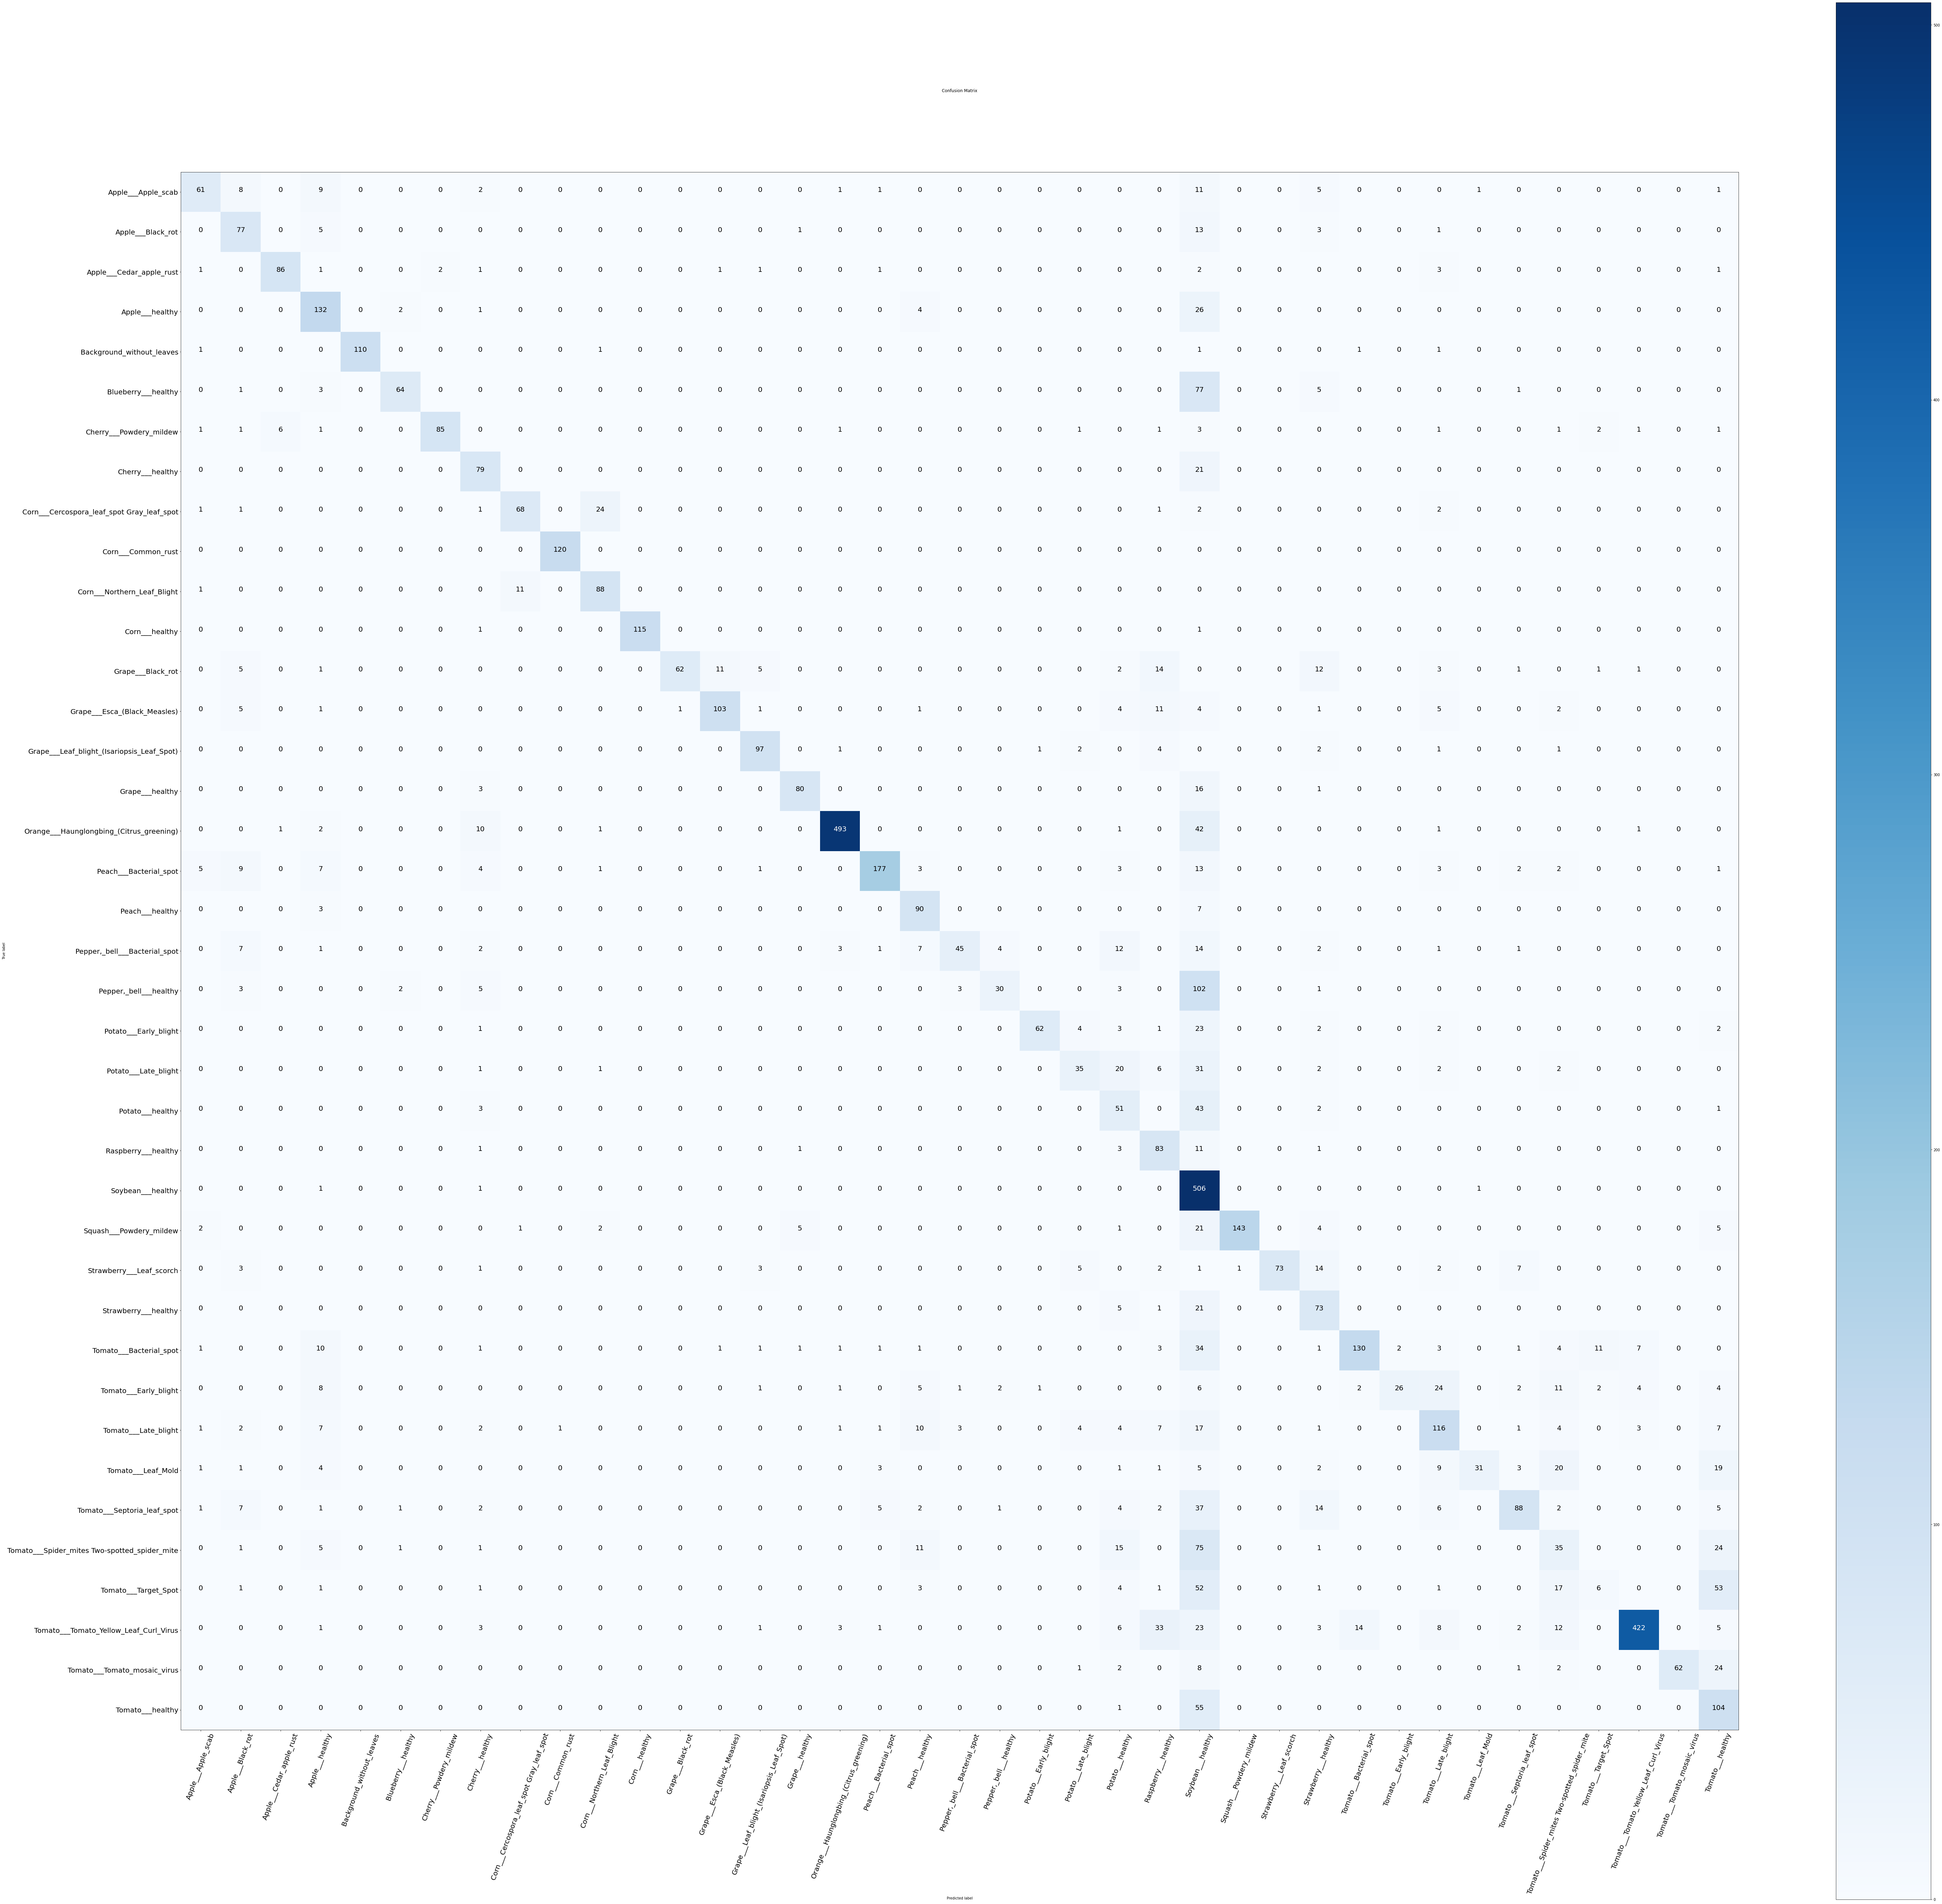

In [ ]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes_5,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

# **Model 6 (Inception V3)**

## **56-Compile and Evaluate The Model**

In [ ]:
# Setup a base model and freeze its layer (this will extract features)
base_model_6 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model_6.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model_6(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_6=tf.keras.Model(inputs, outputs)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of model we've been created
model_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_avg_pooling_layer (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 output_layer (Dense)        (None, 39)                3997

In [ ]:
# Compile
model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_6 = model_6.fit(train_data,
                    epochs=10, # fit to 10 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/10
1537/1537 [==============================] - 465s 298ms/step - loss: 4.7431 - tp: 7609.0000 - fp: 5401.0000 - tn: 2097785.0000 - fn: 47738.0000 - accuracy: 0.2827 - precision: 0.5849 - recall: 0.1375 - auc: 0.8287 - val_loss: 3.2534 - val_tp: 427.0000 - val_fp: 700.0000 - val_tn: 232582.0000 - val_fn: 5712.0000 - val_accuracy: 0.1925 - val_precision: 0.3789 - val_recall: 0.0696 - val_auc: 0.7864
Epoch 2/10
1537/1537 [==============================] - 244s 158ms/step - loss: 2.4141 - tp: 6117.0000 - fp: 3051.0000 - tn: 1865751.0000 - fn: 43062.0000 - accuracy: 0.3188 - precision: 0.6672 - recall: 0.1244 - auc: 0.8876 - val_loss: 2.8103 - val_tp: 659.0000 - val_fp: 633.0000 - val_tn: 232649.0000 - val_fn: 5480.0000 - val_accuracy: 0.2500 - val_precision: 0.5101 - val_recall: 0.1073 - val_auc: 0.8428
Epoch 3/10
1537/1537 [==============================] - 196s 127ms/step - loss: 2.3086 - tp: 7413.0000 - fp: 3504.0000 - tn: 1865298.0000 - fn: 41766.0000 - accuracy: 0.3486 - prec

In [ ]:
inception_feature_extractor = model_6.evaluate(test_data)
inception_feature_extractor

193/193 [==============================] - 17s 87ms/step - loss: 2.5952 - tp: 880.0000 - fp: 514.0000 - tn: 233870.0000 - fn: 5288.0000 - accuracy: 0.3064 - precision: 0.6313 - recall: 0.1427 - auc: 0.8632


[2.5951647758483887,
 880.0,
 514.0,
 233870.0,
 5288.0,
 0.306420236825943,
 0.6312769055366516,
 0.1426718533039093,
 0.8632091283798218]

## **57-Fine-Tune Inception V3 Model**

In [ ]:
# Unfreeze all of the layers in base model
base_model_6.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model_6.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

## **58-Recompile and Evaluate The Model**

In [ ]:
# Fine-tune for more 5 epochs
fine_tune_epochs_6 = 20 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune_6 = model_6.fit(train_data,
                              epochs=fine_tune_epochs_6,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history_6.epoch[-1])

Epoch 10/20
1537/1537 [==============================] - 154s 96ms/step - loss: 1.9233 - tp: 12968.0000 - fp: 4350.0000 - tn: 2098836.0000 - fn: 42379.0000 - accuracy: 0.4310 - precision: 0.7488 - recall: 0.2343 - auc: 0.9240 - val_loss: 2.3127 - val_tp: 1209.0000 - val_fp: 675.0000 - val_tn: 232607.0000 - val_fn: 4930.0000 - val_accuracy: 0.3580 - val_precision: 0.6417 - val_recall: 0.1969 - val_auc: 0.8943
Epoch 11/20
1537/1537 [==============================] - 147s 95ms/step - loss: 1.9007 - tp: 12249.0000 - fp: 3959.0000 - tn: 1864843.0000 - fn: 36930.0000 - accuracy: 0.4487 - precision: 0.7557 - recall: 0.2491 - auc: 0.9337 - val_loss: 2.3394 - val_tp: 1183.0000 - val_fp: 703.0000 - val_tn: 232579.0000 - val_fn: 4956.0000 - val_accuracy: 0.3598 - val_precision: 0.6273 - val_recall: 0.1927 - val_auc: 0.8911
Epoch 12/20
1537/1537 [==============================] - 145s 94ms/step - loss: 1.9029 - tp: 12321.0000 - fp: 3957.0000 - tn: 1864845.0000 - fn: 36858.0000 - accuracy: 0.4533 -

In [ ]:
# Evaluate on the whole test dataset
fine_tune_inception_results =model_6.evaluate(test_data)
fine_tune_inception_results

193/193 [==============================] - 16s 81ms/step - loss: 2.2657 - tp: 1274.0000 - fp: 659.0000 - tn: 233725.0000 - fn: 4894.0000 - accuracy: 0.3729 - precision: 0.6591 - recall: 0.2065 - auc: 0.8991


[2.265681743621826,
 1274.0,
 659.0,
 233725.0,
 4894.0,
 0.3728923499584198,
 0.6590791344642639,
 0.20654994249343872,
 0.8990561366081238]

## **59-Compare Histories**

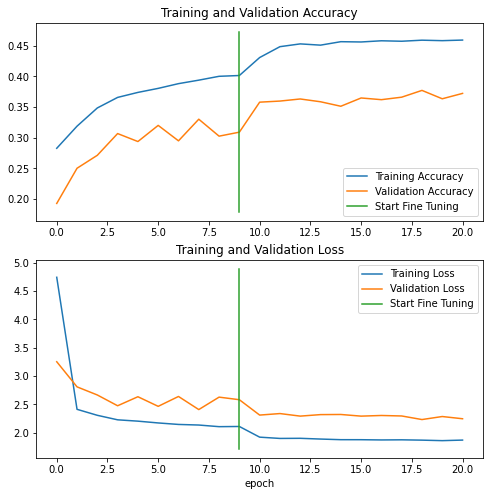

In [ ]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_6,
                 new_history=history_fine_tune_6,
                 initial_epochs=10)

## **60-Make Predictions**

In [ ]:
# Make predictions with model
preds_probs_6 = model_6.predict(test_data, verbose=1) # set verbosity to see how long it left

193/193 [==============================] - 15s 74ms/step


In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs_6[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs_6[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs_6[0].argmax()}")

Number of prediction probabilites for sample 0: 39
What prediction probabilites sample 0 looks like:
 [6.4205796e-02 9.3465149e-02 2.0417974e-03 1.3103809e-02 2.6133662e-02
 4.4774474e-03 2.1024344e-03 1.6340822e-05 2.3398872e-02 2.3946913e-02
 2.4299491e-03 1.6212086e-04 2.7356661e-04 6.9431105e-04 1.6313820e-03
 4.4829627e-05 1.0127264e-02 1.5696976e-02 1.7824434e-02 3.5919124e-01
 8.1406929e-02 9.2253655e-02 1.2906081e-02 4.5700825e-04 4.5259465e-05
 4.2960787e-04 2.7605670e-03 2.1068440e-04 5.1705530e-03 2.5104003e-03
 1.7679064e-02 4.4304647e-02 1.6827939e-02 2.0528134e-02 7.1923346e-03
 1.4666965e-02 1.3034259e-02 3.3579092e-04 6.3118618e-03]
The class with highest predicted probability by the model for sample 0: 19


In [ ]:
# Get the pred classes of each model
pred_classes_6 = preds_probs_6.argmax(axis=1)

# How do they look like?
pred_classes_6[:10]

array([19, 20, 17,  4,  9, 17,  0, 36, 14,  0])

In [ ]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust']

## **61-Make Confusion Matrix**

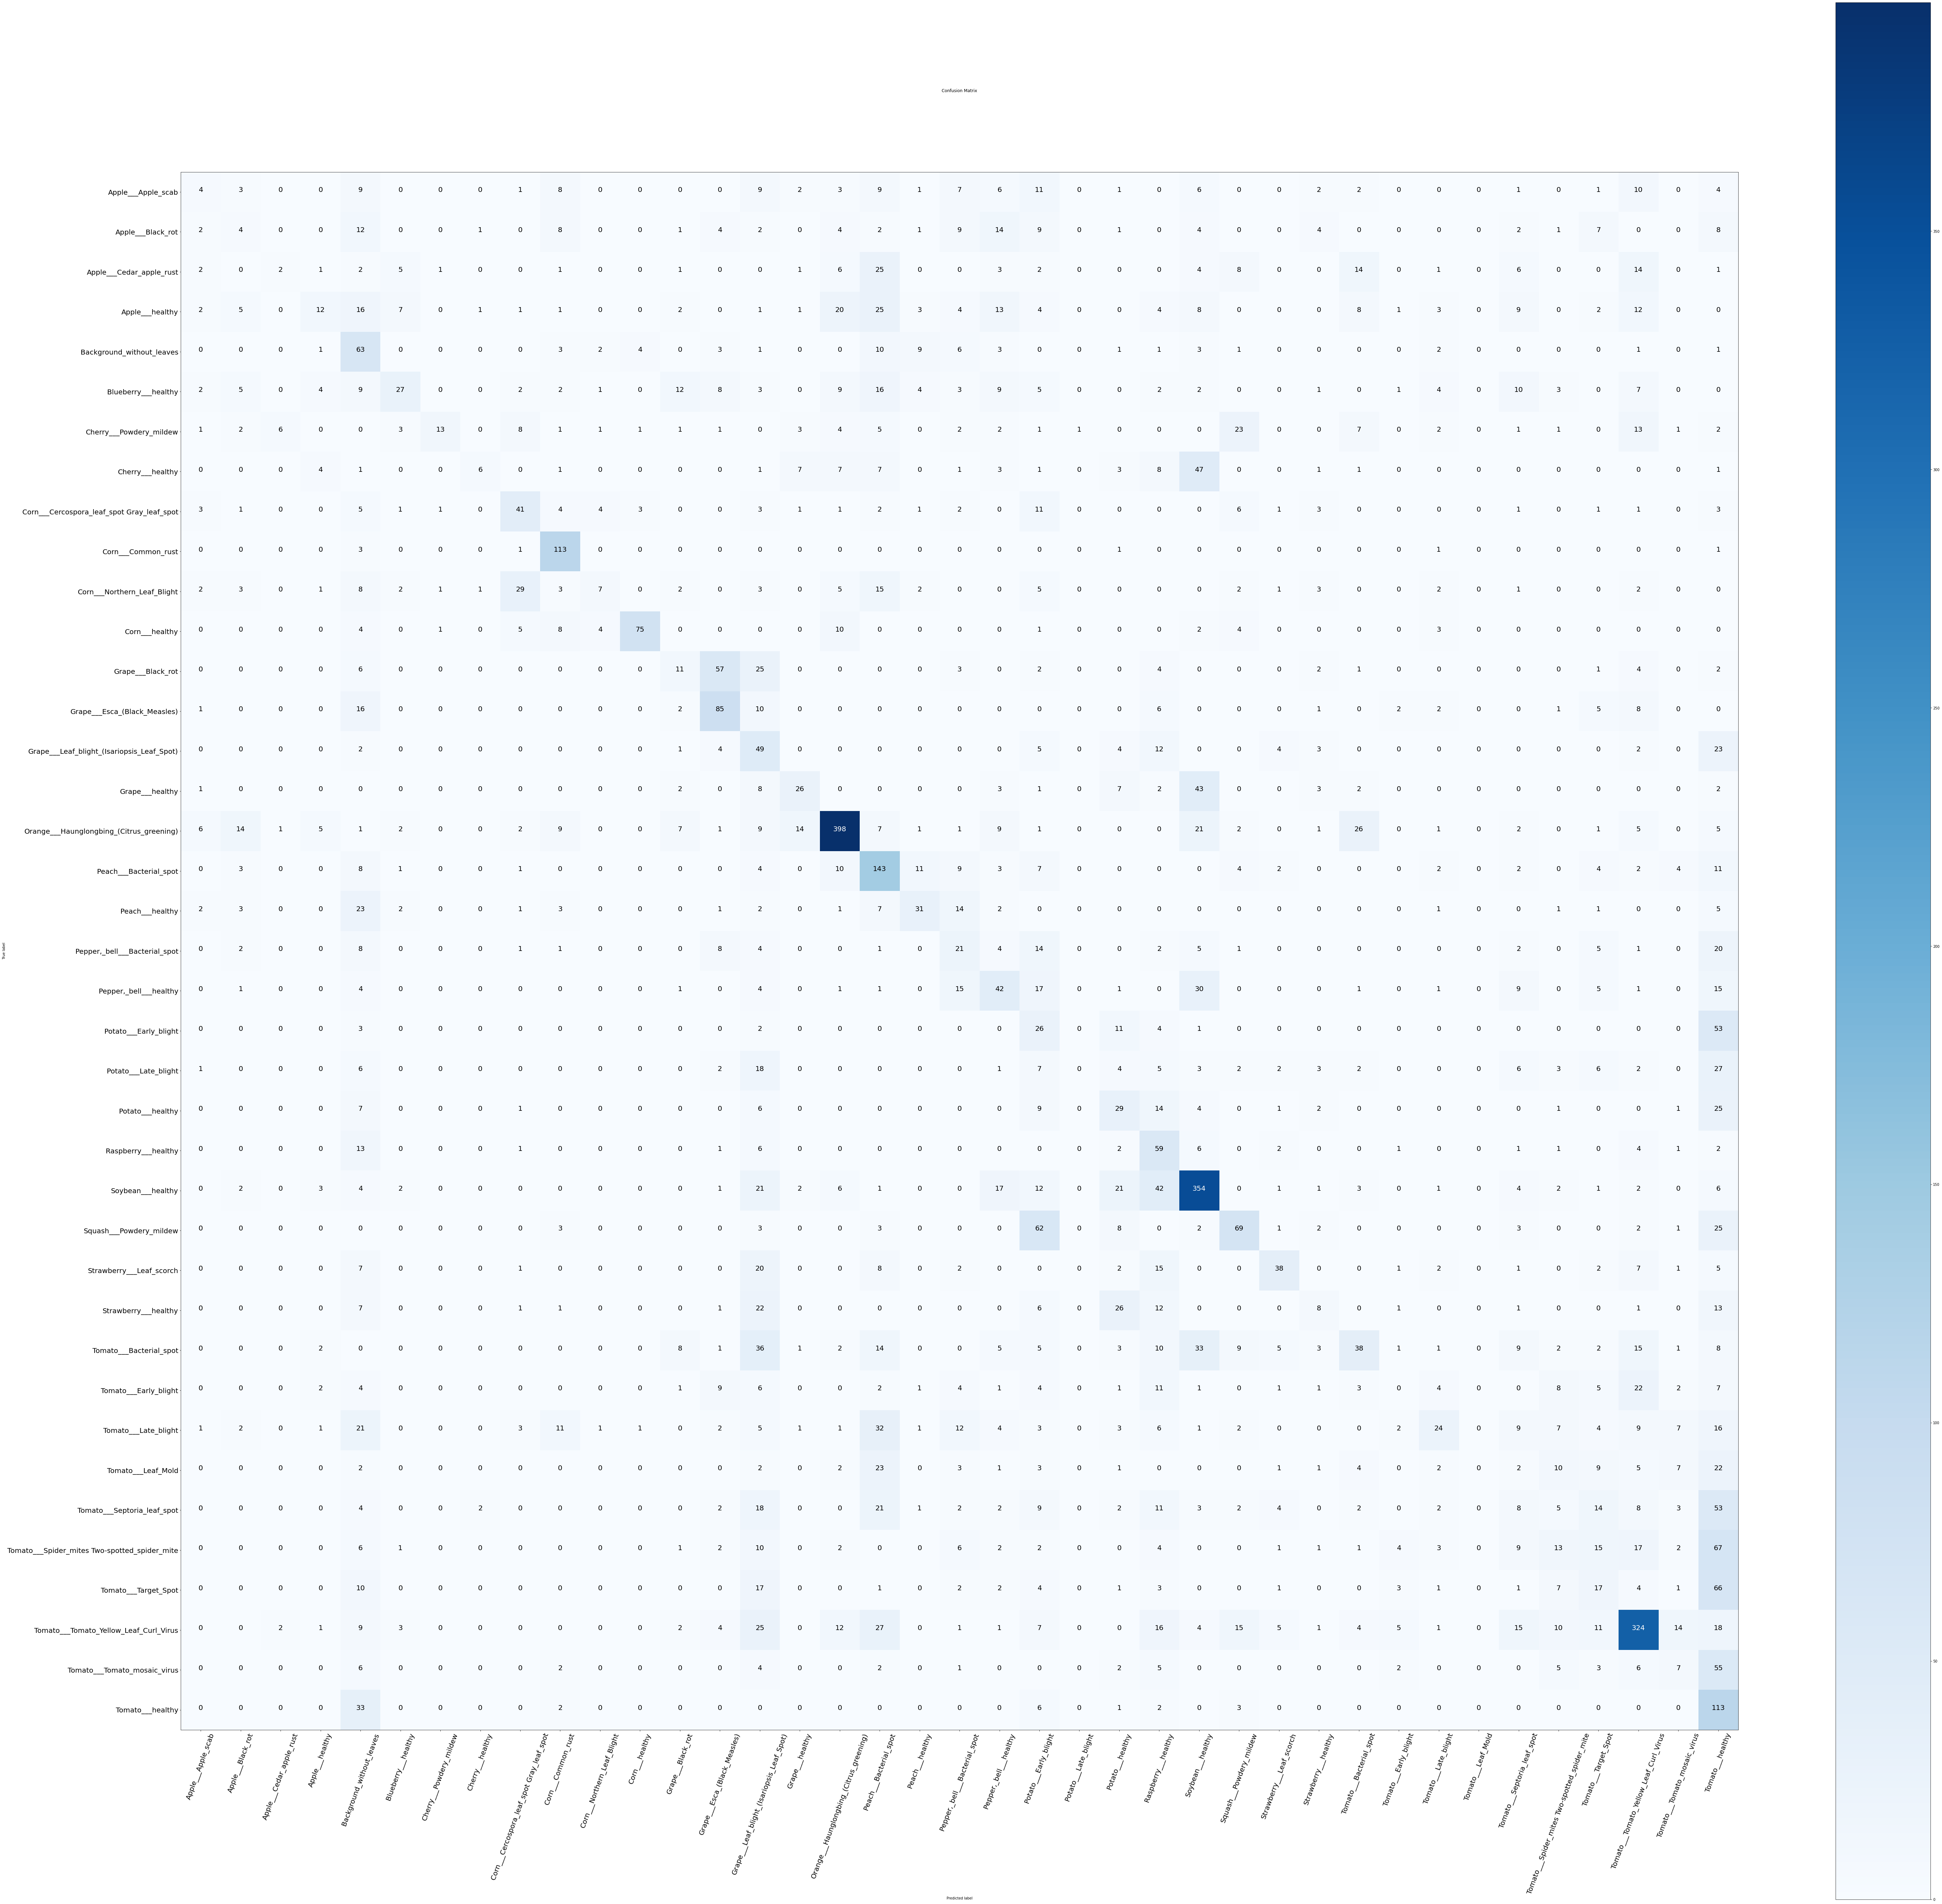

In [ ]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes_6,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)